# Settings

## Constant

In [1]:
import pytz
import os


DEFAULT_TZ = pytz.FixedOffset(540)  # GMT+09:00; Asia/Seoul

PATH_DATA = './data'
PATH_ESM = os.path.join(PATH_DATA, 'EsmResponse.csv')
PATH_PARTICIPANT = os.path.join(PATH_DATA, 'UserInfo.csv')
PATH_SENSOR = os.path.join(PATH_DATA, 'Sensor')

PATH_INTERMEDIATE = './intermediate'

DATA_TYPES = {
    'EDA': 'EDA',
    'HR': 'HRT',
    'RRI': 'RRI',
    'SkinTemperature': 'SKT',
}


## Utility Functions

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import cloudpickle
import ray
from datetime import datetime
from contextlib import contextmanager
import warnings
import time


def load(path: str):
    with open(path, mode='rb') as f:
        return cloudpickle.load(f)
    
def dump(obj, path: str):
    with open(path, mode='wb') as f:
        cloudpickle.dump(obj, f)
    
def log(msg: any):
    print('[{}] {}'.format(datetime.now().strftime('%y-%m-%d %H:%M:%S'), msg))

def summary(x):
    x = np.asarray(x)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        n = len(x)
        # Here, uppercase np.dtype.kind corresponds to non-numeric data.
        # Also, we view the boolean data as dichotomous categorical data.
        if x.dtype.kind.isupper() or x.dtype.kind == 'b': 
            cnt = pd.Series(x).value_counts(dropna=False)
            card = len(cnt)
            cnt = cnt[:20]                
            cnt_str = ', '.join([f'{u}:{c}' for u, c in zip(cnt.index, cnt)])
            if card > 30:
                cnt_str = f'{cnt_str}, ...'
            return {
                'n': n,
                'cardinality': card,
                'value_count': cnt_str
            }
        else: 
            x_nan = x[np.isnan(x)]
            x_norm = x[~np.isnan(x)]
            
            tot = np.sum(x_norm)
            m = np.mean(x_norm)
            me = np.median(x_norm)
            s = np.std(x_norm, ddof=1)
            l, u = np.min(x_norm), np.max(x)
            conf_l, conf_u = st.t.interval(0.95, len(x_norm) - 1, loc=m, scale=st.sem(x_norm))
            n_nan = len(x_nan)
            
            return {
                'n': n,
                'sum': tot,
                'mean': m,
                'SD': s,
                'med': me,
                'range': (l, u),
                'conf.': (conf_l, conf_u),
                'nan_count': n_nan
            }


@contextmanager
def on_ray(*args, **kwargs):
    try:
        if ray.is_initialized():
            ray.shutdown()
        ray.init(*args, **kwargs)
        yield None
    finally:
        ray.shutdown()

## Settings for R

In [3]:
# %load_ext rpy2.ipython

In [4]:
# %%R

# library(tidyverse)
# library(ggforce)
# library(ggpubr)
# library(showtext)
# library(rmcorr)
# library(patchwork)

# # font_add_google(
# #     name='Source Serif Pro',
# #     family='ssp',
# #     db_cache=FALSE
# # )

# showtext_auto()

# THEME_DEFAULT <- theme_bw(
#     base_size=10,
#     base_family='ssp',
# ) + theme(
#         axis.title.x=element_text(colour='grey20', size=10, face='bold'),
#         axis.title.y=element_text(colour='grey20', size=10, face='bold'),
#         axis.text.x=element_text(colour='grey20', size=10),
#         axis.text.y=element_text(colour='grey20', size=10),
#         strip.text.x=element_text(colour='grey20', size=10, face='bold'),
#         strip.text.y=element_text(colour='grey20', size=10, face='bold'),
#         legend.background=element_blank(),
#         legend.title=element_text(colour='grey20', size=10, face='bold'),
#         legend.text=element_text(colour='grey20', size=10),
#         legend.position='top',
#         legend.box.spacing= unit(0, 'cm'),
#         plot.subtitle=element_text(colour='grey20', size=10, hjust=.5),
#     )


# Dataset Overview

## Participants

In [5]:
import pandas as pd
import os


PARTICIPANTS = pd.read_csv(PATH_PARTICIPANT).set_index('pcode').assign(
    particpationStartDateTime=lambda x: pd.to_datetime(
        x['participationStartDate'], format='%Y-%m-%d'
    ).dt.tz_localize(DEFAULT_TZ)
)
PARTICIPANTS.head()

,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ,particpationStartDateTime
pcode,,,,,,,,,,,,
P01,2019-05-08,27,M,11,11,3,4,13,13,0,1,2019-05-08 00:00:00+09:00
P02,2019-05-08,21,M,14,5,12,14,5,27,6,18,2019-05-08 00:00:00+09:00
P03,2019-05-08,24,F,10,15,8,7,11,18,2,6,2019-05-08 00:00:00+09:00
P04,2019-05-08,23,M,12,11,8,6,11,20,1,9,2019-05-08 00:00:00+09:00
P05,2019-05-08,27,F,10,11,13,10,6,25,14,9,2019-05-08 00:00:00+09:00


Belows are some demographics:

In [6]:
for c in PARTICIPANTS.columns:
    print(f'- {c}:', summary(PARTICIPANTS[c]))

- participationStartDate: {'n': 77, 'cardinality': 3, 'value_count': '2019-05-08:27, 2019-05-16:25, 2019-04-30:25'}
- age: {'n': 77, 'sum': 1686, 'mean': 21.896103896103895, 'SD': 3.8613619617422406, 'med': 21.0, 'range': (17, 38), 'conf.': (21.01968223607122, 22.77252555613657), 'nan_count': 0}
- gender: {'n': 77, 'cardinality': 2, 'value_count': 'M:53, F:24'}
- openness: {'n': 77, 'sum': 787, 'mean': 10.220779220779221, 'SD': 2.8956563505732467, 'med': 11.0, 'range': (3, 15), 'conf.': (9.563545847995773, 10.87801259356267), 'nan_count': 0}
- conscientiousness: {'n': 77, 'sum': 820, 'mean': 10.64935064935065, 'SD': 2.3662441579221882, 'med': 11.0, 'range': (5, 15), 'conf.': (10.112279104782713, 11.186422193918586), 'nan_count': 0}
- neuroticism: {'n': 77, 'sum': 618, 'mean': 8.025974025974026, 'SD': 2.6900108881310953, 'med': 8.0, 'range': (3, 14), 'conf.': (7.4154164477308075, 8.636531604217245), 'nan_count': 0}
- extraversion: {'n': 77, 'sum': 703, 'mean': 9.12987012987013, 'SD': 3.

## Labels (via ESM)

In [7]:
import pandas as pd
import os


LABELS = pd.read_csv(PATH_ESM).set_index(
    ['pcode']
)
LABELS.head()

,responseTime,scheduledTime,valence,arousal,attention,stress,duration,disturbance,change
pcode,,,,,,,,,
P01,1557278103000,NaN,0,0,0,-1,20.0,3,-2
P01,1557278986000,1.557279e+12,-3,3,3,3,5.0,-1,-3
P01,1557281772000,1.557282e+12,-3,-2,2,2,15.0,3,-2
P01,1557287138000,NaN,2,-1,2,0,15.0,1,-1
P01,1557291117000,NaN,3,3,3,-3,20.0,1,0


In [8]:
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.9048), 'nan_count': 0}
- scheduledTime: {'n': 5582, 'sum': 5175814282500000.0, 'mean': 1557572760306.9517, 'SD': 591697484.8543198, 'med': 1557565860000.0, 'range': (1556586120000.0, nan), 'conf.': (1557552635074.4736, 1557592885539.4297), 'nan_count': 2259}
- valence: {'n': 5582, 'sum': 3665, 'mean': 0.6565747044070226, 'SD': 1.4184297545899174, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.6193565182132938, 0.6937928906007513), 'nan_count': 0}
- arousal: {'n': 5582, 'sum': -529, 'mean': -0.09476890003582945, 'SD': 1.6675313128774563, 'med': 0.0, 'range': (-3, 3), 'conf.': (-0.13852326339835566, -0.051014536673303246), 'nan_count': 0}
- attention: {'n': 5582, 'sum': 2236, 'mean': 0.4005732712289502, 'SD': 1.6113242733571864, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.35829372468

Belows are some demographics:

In [9]:
inst = LABELS.groupby('pcode').count().iloc[:, -1]
inst_sch = LABELS.loc[lambda x: ~x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
inst_vol = LABELS.loc[lambda x: x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
resp_time = LABELS.assign(
    timestamp=lambda x: pd.to_datetime(x['responseTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
)
sam = np.concatenate([
    (resp_time.loc[p, 'timestamp'].array - resp_time.loc[p, 'timestamp'].array.shift(1)).dropna().total_seconds()
    for p in LABELS.index.unique()
])

print('- # Inst.:', summary(inst))
print('- # Inst. - Scheduled:', summary(inst_sch))
print('- # Inst. - Voluntary:', summary(inst_vol))
print('- Samp. period:', summary(sam))
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- # Inst.: {'n': 77, 'sum': 5582, 'mean': 72.49350649350649, 'SD': 16.02270048911147, 'med': 74.0, 'range': (20, 110), 'conf.': (68.85679957506535, 76.13021341194762), 'nan_count': 0}
- # Inst. - Scheduled: {'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768289902, 48.14830073815361), 'nan_count': 0}
- # Inst. - Voluntary: {'n': 77, 'sum': 2259, 'mean': 29.337662337662337, 'SD': 16.297893300742235, 'med': 27.0, 'range': (2, 74), 'conf.': (25.6384943127028, 33.03683036262187), 'nan_count': 0}
- Samp. period: {'n': 5505, 'sum': 42240670.0, 'mean': 7673.146230699364, 'SD': 13193.471538029606, 'med': 3090.0, 'range': (1.0, 136446.0), 'conf.': (7324.548923384188, 8021.743538014541), 'nan_count': 0}
- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.9048)

### Plot

In [10]:
data = LABELS.loc[
    :, lambda x: ~x.columns.isin(['responseTime', 'scheduledTime'])
]

In [11]:
# %%R -i data -w 16 -h 6 -u cm

# data <- data %>% pivot_longer(
#     cols = c('valence', 'arousal', 'attention', 'stress', 'duration', 'disturbance', 'change'),
#     names_to = 'metric'
# )

# p_rest <- ggplot(
#     data %>% filter(metric != 'duration'), aes(x=metric, y=value)
# ) + geom_boxplot(
# ) + geom_point(
#     data = data %>% filter(
#         metric != 'duration'
#     ) %>% group_by(
#         metric
#     ) %>% summarise(
#         mean = mean(value, na.rm=TRUE)
#     ),
#     mapping=aes(x=metric, y=mean),
#     shape=21,
#     stroke=1,
#     size=2,
#     fill='white'
# ) + scale_x_discrete(
#     name=NULL,
#     limits=c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'),
#     labels=c('Valence', 'Arousal', 'Stress', 'Attent.', 'Disturb.', 'Change'),
# ) + scale_y_continuous(
#     name='Response',
#     breaks=-3:3
# ) + THEME_DEFAULT

# p_duration <- ggplot(
#     data %>% filter(metric == 'duration'), aes(x=metric, y=value)
# ) + geom_boxplot(
# ) + geom_point(
#     data = data %>% filter(
#         metric == 'duration'
#     ) %>% group_by(
#         metric
#     ) %>% summarise(
#         mean = mean(value, na.rm=TRUE)
#     ),
#     mapping=aes(x=metric, y=mean),
#     shape=21,
#     stroke=1,
#     size=2,
#     fill='white'
# )+ scale_x_discrete(
#     name=NULL,
#     limits=c('duration'),
#     labels=c('Duration'),
# ) + scale_y_continuous(
#     name=NULL,
#     breaks=seq(from=5, to=60, by=10)
# ) + THEME_DEFAULT

# p <- p_rest + p_duration + plot_layout(widths=c(4, 0.8))
# ggsave('./fig/dist-labels.pdf', plot=p, width=16, height=6, unit='cm', device=cairo_pdf)
# print(p)

### Correlation

Because each participant reported their labels multiple times (i.e., repeated measure), repeated measure correlation between affect labels were used.

In [12]:
data = LABELS.reset_index()[[
    'pcode', 'valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'
]]

In [13]:
# %%R -i data 

# com <- combn(c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'), 2)

# for(i in 1:ncol(com)) {
#     a <- com[, i][1]
#     b <- com[, i][2]
#     r <- rmcorr(participant = 'pcode', measure1=a, measure2=b, dataset=data)
#     cat(a, '-', b, ': R =', r$r, '(p =', r$p, ') \n')
# }

## Sensor Data

In [14]:
import os
import pandas as pd
from typing import Optional


def _load_data(
    name: str
) -> Optional[pd.DataFrame]:
    paths = [
        (d, os.path.join(PATH_SENSOR, d, f'{name}.csv'))
        for d in os.listdir(PATH_SENSOR)
        if d.startswith('P')
    ]
    return pd.concat(
        filter(
            lambda x: len(x.index), 
            [
                pd.read_csv(p).assign(pcode=pcode)
                for pcode, p in paths
                if os.path.exists(p)
            ]
        ), ignore_index=True
    ).assign(
        timestamp=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
    ).set_index(
        ['pcode', 'timestamp']
    )

In [15]:
import pandas as pd
import gc
from datetime import timedelta as td


# STATS = []

# for data_type in DATA_TYPES:
#     dat = _load_data(data_type)
#     inst = dat.groupby('pcode').count().iloc[:, -1]
#     samp = np.concatenate([
#         (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
#         for p in dat.index.get_level_values('pcode').unique()
#     ])
#     inst, samp = summary(inst), summary(samp)
    
#     print('#'*5, data_type, '#'*5)
#     print('- # Inst.:', inst)
#     print('- Samp. period:', samp)
    
#     for c in dat.columns:
#         print(f'- {c}:', summary(dat[c]))
        
#     del dat
#     gc.collect()
    
# STATS = pd.DataFrame(STATS)

# Preprocessing

## Label

Because we intended to collected participants' responses to ESMs not voluntary responses, we screend out some responses as follows:
* We first screen out ESM responses that does not have 'scheduledTime' (meaning that a given ESM was expired or participants voluntarily reported their affective states regardless of ESM delivery). 
* Since we will evaluate our model using LOSO, the small number of responses for each participant might lead to inappropriate performance evaluation. We emprically set the number of the minimum responses upon ESM delivery as 5 per day (i.e., a half of our guides), so that we excluded participants whose responses to ESM less than 35.

In [16]:
LABELS_VALID = LABELS.loc[
    lambda x: ~x['scheduledTime'].isna(), :
]
# print(LABELS_VALID)
# print(f'# Non-voluntary response: {len(LABELS_VALID)}')
# print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

excl_pcode = LABELS_VALID.loc[
    lambda x: ~x['scheduledTime'].isna()
].groupby('pcode').count().iloc[:, -1].loc[lambda y: y < 35]

LABELS_VALID = LABELS_VALID.loc[
    lambda x:  ~x.index.get_level_values('pcode').isin(excl_pcode.index), :
]
print(f'# Response from participants with enough responses: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

print('# Participants whose responses to ESM delivery were less then 35')
# print(excl_pcode, f'#participants = {len(excl_pcode)} / #response = {sum(excl_pcode)}')
print(f'# participants = {len(excl_pcode)} / #response = {sum(excl_pcode)}')

# LABELS_VALID # 참여자: 47명, 응답 2619개
# 35개의 응답 보다 작은 참여자: 29명 (47/2619 -> 29/704)

# 연구는 47명으로 진행

# Response from participants with enough responses: 2619
{'n': 47, 'sum': 2619, 'mean': 55.723404255319146, 'SD': 13.076201628480542, 'med': 52.0, 'range': (36, 83), 'conf.': (51.88408762653044, 59.562720884107854), 'nan_count': 0}
# Participants whose responses to ESM delivery were less then 35
# participants = 29 / #response = 704


Here we consider binary classifications for valence, arousal, stress, and disturbance, in which a label value greater than 0 is "HIGH" (1) and the rest is "LOW" (0), at the arrival of ESM prompts (*scheduledTime*)

In [17]:
import pandas as pd
import numpy as np

LABELS_PROC = (
    LABELS_VALID
    .reset_index()
    .assign(
        timestamp=lambda x: pd.to_datetime(x['scheduledTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ),
        attention_bin=lambda x: np.where(x['attention'] > 0, 1, 0)
    )
    .loc[:, ['pcode', 'timestamp', 'attention', 'attention_bin']]  # attention: 연속형, attention_bin: 이진분류된 데이터
    .set_index(['pcode', 'timestamp'])
)

LABELS_PROC

attention  attention_bin
pcode timestamp                                          
P01   2019-05-08 10:26:00+09:00          3              1
      2019-05-08 11:13:00+09:00          2              1
      2019-05-08 15:56:00+09:00          3              1
      2019-05-08 16:41:00+09:00          3              1
      2019-05-08 17:23:00+09:00          3              1
...                                    ...            ...
P80   2019-05-05 21:57:00+09:00         -3              0
      2019-05-06 15:06:00+09:00         -2              0
      2019-05-06 15:53:00+09:00          3              1
      2019-05-06 19:39:00+09:00         -1              0
      2019-05-06 21:08:00+09:00          3              1

[2619 rows x 2 columns]

In [18]:
from datetime import timedelta

# 10분 범위 설정
TIME_DELTA = timedelta(minutes=10)

# 결과를 저장할 리스트
rows = []

# 각 pcode별로 반복
for pcode, group in LABELS_PROC.groupby(level='pcode'):
    group = group.reset_index()

    # 각 attention_bin이 있는 행에 대해
    for _, row in group.iterrows():
        ts = row['timestamp']
        bin_val = row['attention_bin']

        # ±10분 범위 내 timestamp 생성
        timestamps = pd.date_range(ts - TIME_DELTA, ts + TIME_DELTA, freq='T', tz=DEFAULT_TZ)

        for t in timestamps:
            rows.append((pcode, t, bin_val))

# 확장된 데이터프레임 생성
LABELS_PROC = pd.DataFrame(rows, columns=['pcode', 'timestamp', 'attention_bin'])

# 중복 제거 및 인덱스 정렬
LABELS_PROC = (
    LABELS_PROC
    .drop_duplicates(subset=['pcode', 'timestamp'], keep='last')
    .set_index(['pcode', 'timestamp'])
    .sort_index()
)

# 확인 출력
print(LABELS_PROC.head(10))

# 이후 코드에 변수명 통일
inst = LABELS_PROC.groupby('pcode').count().iloc[:, -1]

for c in [c for c in LABELS_PROC.columns if c.endswith('_bin')]:
    print(f'- {c}:', summary(LABELS_PROC[c].astype(object)))

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/2547955742.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(ts - TIME_DELTA, ts + TIME_DELTA, freq='T', tz=DEFAULT_TZ)
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/2547955742.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(ts - TIME_DELTA, ts + TIME_DELTA, freq='T', tz=DEFAULT_TZ)
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/2547955742.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(ts - TIME_DELTA, ts + TIME_DELTA, freq='T', tz=DEFAULT_TZ)
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/2547955742.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ti

                                 attention_bin
pcode timestamp                               
P01   2019-05-08 10:16:00+09:00              1
      2019-05-08 10:17:00+09:00              1
      2019-05-08 10:18:00+09:00              1
      2019-05-08 10:19:00+09:00              1
      2019-05-08 10:20:00+09:00              1
      2019-05-08 10:21:00+09:00              1
      2019-05-08 10:22:00+09:00              1
      2019-05-08 10:23:00+09:00              1
      2019-05-08 10:24:00+09:00              1
      2019-05-08 10:25:00+09:00              1
- attention_bin: {'n': 54999, 'cardinality': 2, 'value_count': '0:27552, 1:27447'}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/2547955742.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(ts - TIME_DELTA, ts + TIME_DELTA, freq='T', tz=DEFAULT_TZ)
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/2547955742.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(ts - TIME_DELTA, ts + TIME_DELTA, freq='T', tz=DEFAULT_TZ)


In [19]:
import numpy as np


inst = LABELS_PROC.groupby('pcode').count().iloc[:, -1]
for c in [c for c in LABELS_PROC.columns if c.endswith('_bin')]:
    print(f'- {c}:', summary(LABELS_PROC[c].astype(object)))

# 총 응답으로 볼 때, attention의 0, 1 클래스는 balanced
# 데이터셋으르 합칠 경우, oversampling 필요 없을 듯.

- attention_bin: {'n': 54999, 'cardinality': 2, 'value_count': '0:27552, 1:27447'}


In [20]:
import pandas as pd

inst = LABELS_PROC.groupby('pcode').count().iloc[:, -1]

for c in [col for col in LABELS_PROC.columns if col.endswith('_bin')]:
    counts = LABELS_PROC.groupby('pcode')[c].value_counts().unstack(fill_value=0)
    ratios = counts.div(counts.sum(axis=1), axis=0)
    stats = pd.DataFrame({
        'n_total': counts.sum(axis=1),
        'n_class_0': counts.get(0, 0),
        'n_class_1': counts.get(1, 0),
        'ratio_0': ratios.get(0, 0),
        'ratio_1': ratios.get(1, 0),
        'imbalance_ratio': counts.max(axis=1) / counts.sum(axis=1)
    })
    print("클래스별 평균 및 표준편차:")
    for col in ['ratio_0', 'ratio_1', 'imbalance_ratio']:
        mean = stats[col].mean()
        std = stats[col].std()
        print(f"  - {col}: 평균 = {mean:.3f}, 표준편차 = {std:.3f}")

# imbalance_ratio: 각 참가자의 샘플의 다수 클래스 비율
# 값이 0.5에 가까우면 균형된 데이터
# 문제: 전체 데이터에서는 균형, 개별 참가자 단위로는 불균형 -> LOGO시 문제 발생 가능성.
# 해결: class_weight='balanced', oversampling, 불균형 참가자 제거, Leave-Multiple-Groups-Out
# 평가지표? F1, ROC-AUC가 불균형에 민감한지?

클래스별 평균 및 표준편차:
  - ratio_0: 평균 = 0.500, 표준편차 = 0.206
  - ratio_1: 평균 = 0.500, 표준편차 = 0.206
  - imbalance_ratio: 평균 = 0.665, 표준편차 = 0.121


## Sensor Data

For each type of sensor data, we applied different preprocessing. Detailed decsription is provided in the paper.



### Implementation

In [21]:
import pandas as pd
import numpy as np
from typing import Dict, Union

# IQR -> 이상치 제거
def _remove_outliers_iqr(series: pd.Series) -> pd.Series:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower=lower, upper=upper)

# 로그 정규화 + Z-score
def _log_normalize(series: pd.Series) -> pd.Series:
    series = series.clip(lower=1)
    log_vals = np.log1p(series)
    return (log_vals - log_vals.mean()) / log_vals.std()

# SkinTemperature.csv
def _proc_skin_temperature(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    temp = data['temperature'].astype('float32')
    temp = _remove_outliers_iqr(temp)
    return (temp - temp.mean()) / temp.std()

# RRI.csv
def _proc_rri(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    rri = data['interval'].astype('float32')
    rri = _remove_outliers_iqr(rri)
    return (rri - rri.mean()) / rri.std()

# HR.csv
def _proc_hr(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    hr = data['bpm'].astype('float32')
    hr = _remove_outliers_iqr(hr)
    return (hr - hr.mean()) / hr.std()

# EDA.csv
def _proc_eda(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    eda = data['resistance'].astype('float32')
    eda = _remove_outliers_iqr(eda)
    return _log_normalize(eda)

### Execution

In [22]:
import pandas as pd
import gc
from functools import reduce
import time

FUNC_PROC = {
    'EDA': _proc_eda,
    'HR': _proc_hr,
    'RRI': _proc_rri,
    'SkinTemperature': _proc_skin_temperature,
}


def _process(data_type: str):
    log(f'Begin to processing data: {data_type}')
    
    abbrev = DATA_TYPES[data_type]
    data_raw = _load_data(data_type)
    data_proc = FUNC_PROC[data_type](data_raw)
    result = dict()
    
    if type(data_proc) is dict:
        for k, v in data_proc.items():
            result[f'{abbrev}_{k}'] = v
    else:
        result[abbrev] = data_proc
        
    log(f'Complete processing data: {data_type}')
    return result


with on_ray(num_cpus=12):
    jobs = []
    
    func = ray.remote(_process).remote
    
    for data_type in DATA_TYPES:
        job = func(data_type)
        jobs.append(job)

    jobs = ray.get(jobs)
    
    # 메모리 최적화를 위해 추가 
    combined_result = {}
    for d in jobs:
        combined_result |= d
    
    t0 = time.time()
    dump(combined_result, os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))
    log(f'[SAVE] done in {time.time() - t0:.1f}s')
    
    del jobs
    gc.collect()

2025-06-01 20:16:04,203	INFO worker.py:1538 -- Started a local Ray instance.


(_process pid=20425) [25-06-01 20:16:05] Begin to processing data: SkinTemperature
(_process pid=20429) [25-06-01 20:16:05] Begin to processing data: EDA
(_process pid=20427) [25-06-01 20:16:05] Begin to processing data: RRI
(_process pid=20428) [25-06-01 20:16:05] Begin to processing data: HR
(_process pid=20425) [25-06-01 20:16:05] Complete processing data: SkinTemperature
(_process pid=20428) [25-06-01 20:16:14] Complete processing data: HR
(_process pid=20427) [25-06-01 20:16:21] Complete processing data: RRI
(_process pid=20429) [25-06-01 20:17:00] Complete processing data: EDA
[25-06-01 20:17:08] [SAVE] done in 0.8s


In [23]:
import os
import gc

# DATA_ITEMS:
# [('EDA', pcode  timestamp                       
# P19    2019-05-08 09:00:00.029000+09:00     10070.0
#        2019-05-08 09:00:00.233000+09:00     10010.0
#        2019-05-08 09:00:00.434000+09:00     10160.0
#        2019-05-08 09:00:00.640000+09:00     10130.0
#        2019-05-08 09:00:00.842000+09:00     10130.0

def _remove_outliers_iqr_np(arr: np.ndarray) -> np.ndarray: # IQR 방식으로 샘플링 주기 이상치 제거
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return arr[(arr >= lower) & (arr <= upper)]



DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))
#categorial, numeric 변수 수 계산
N_NUMERIC, N_CATEGORICAL = 0, 0

for k, v in DATA.items():
    if v.dtype.kind.isupper() or v.dtype.kind == 'b': 
        N_CATEGORICAL += 1
    else:
        N_NUMERIC += 1

    inst = v.groupby('pcode').count()
    
    # 샘플링 주기 계산 및 이상치 제거
    sam = np.concatenate([
        (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
        for p in v.index.get_level_values('pcode').unique()
    ])
    sam = _remove_outliers_iqr_np(sam)

    
    print('#'*5, k, '#'*5, )
#     print('- # Inst.:', inst)
    print('- Samp. period:', summary(sam))
    print('- Values', summary(v))
    print('')
    
    
print(f'# categorical data: {N_CATEGORICAL}/# numeric data: {N_NUMERIC}')
del DATA
gc.collect()

# IQR 방식으로 샘플링 주기 이상치 제거 전
# | 센서   | 샘플링 주기 평균 (s)     | 샘플링 주기 SD    
# |-------|----------------------|----------------
# | EDA   | 0.514                | 140.55         
# | HRT   | 3.008                | 362.92         
# | RRI   | 1.985                | 276.20         
# | SKT   | 77.03                | 1,719.19       

# IQR 방식으로 샘플링 주기 이상치 제거 후
# | 센서   | 샘플링 주기 평균 (s)     | 샘플링 주기 SD    
# |-------|----------------------|----------------
# | EDA   | 0.199                | 0.013          
# | HRT   | 0.996                | 0.014          
# | RRI   | 0.761                | 0.172          
# | SKT   | 30.08                | 0.014          

# - EDA:
#   · 많이 이상함. 전처리 필요
#   · 매우 빠른 샘플링(0.5초), 샘플링 주기의 표준편차가 매우 큼. 
#   · 샘플 누락, 중단, 오류 구간의 존재 가능성?, 극단적으로 큰 샘플링 주기가 존재?
#     -> 이상치 제거, 리샘플링, (스케일이 너무 큼 -> 정규화(로그 변환, 정규화))
#   · 측정값이 큼 -> log 변환 고려?

# - HRT:
#   · 평균 주기 3초, SD=362초 -> 이것도 이상함, 이상치 제거 필요?
#   · 평균, 표준편차 왜곡?
#

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/1220431816.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### EDA #####
- Samp. period: {'n': 71161950, 'sum': 14178099.724999897, 'mean': 0.19923708842998114, 'SD': 0.01263709088351348, 'med': 0.199, 'range': (0.164, 0.235), 'conf.': (0.19923415232697866, 0.19924002453298362), 'nan_count': 0}
- Values {'n': 80150329, 'sum': -2529.9434, 'mean': -3.1564978e-05, 'SD': 0.99999815, 'med': -0.10594783, 'range': (-4.833558, 1.4691741), 'conf.': (-0.0002504896157723061, 0.00018735966039347936), 'nan_count': 0}



/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/1220431816.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### HRT #####
- Samp. period: {'n': 12126885, 'sum': 12080570.162999991, 'mean': 0.9961808133745799, 'SD': 0.013881222953694618, 'med': 0.996, 'range': (0.956, 1.036), 'conf.': (0.9961730006730264, 0.9961886260761333), 'nan_count': 0}
- Values {'n': 13621023, 'sum': 114.31421, 'mean': 8.392483e-06, 'SD': 1.0, 'med': -0.034554552, 'range': (-2.3233254, 2.2542164), 'conf.': (-0.0005226671196859384, 0.0005394520863327485), 'nan_count': 0}



/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/1220431816.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### RRI #####
- Samp. period: {'n': 20153483, 'sum': 15346016.337999996, 'mean': 0.7614572795183838, 'SD': 0.17227250402189642, 'med': 0.76, 'range': (0.308, 1.215), 'conf.': (0.761382067191175, 0.7615324918455927), 'nan_count': 0}
- Values {'n': 20764471, 'sum': 4.092726157978177e-11, 'mean': 1.971023561340993e-18, 'SD': 1.0000000000000007, 'med': 0.04632033346408256, 'range': (-2.4651769846616585, 2.4630442731345945), 'conf.': (-0.00043011806230934996, 0.00043011806230935386), 'nan_count': 0}

##### SKT #####
- Samp. period: {'n': 466247, 'sum': 14025575.527000003, 'mean': 30.081856884870042, 'SD': 0.014188487166116254, 'med': 30.082, 'range': (30.04, 30.123), 'conf.': (30.08181615835165, 30.081897611388435), 'nan_count': 0}
- Values {'n': 535095, 'sum': 2.2646418074145913e-10, 'mean': 4.232223824581787e-16, 'SD': 1.0000000000000002, 'med': 0.13509866738899262, 'range': (-2.527910477209998, 2.629919190267469), 'conf.': (-0.002679375777865103, 0.0026793757778659495), 'nan_count': 0}

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/1220431816.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


0

# Feature Extraction

## Implementation

In [24]:
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable
from datetime import timedelta as td
from scipy import stats
from scipy.interpolate import CubicSpline
import ray
import warnings
import time

def _safe_na_check(_v):
    _is_nan_inf = False
    try:
        _is_nan_inf = np.isnan(_v) or np.isinf(_v)
    except:
        _is_nan_inf = False
    return _is_nan_inf or _v is None

# _extract: 한 명의 참가자(pid)의 feature 생성
# _extract 출력:
# X: DataFrame(n, f) / n = 라벨 개수, f = 추출된 feature 수 / row: timestamp에 대한 feature vector, col: 센서, 시간 기반 피쳐
# y: np.ndarray(n,) / timestamp별 라벨(1D)
# group: np.ndarray(n,) / 참가자 ID 반복 배열 (모델 그룹 분리용) / 각 row 별 pid - KFold, LOGO에 사용 / 입력 파라미터의 pid와 동일값 반복
# date_times: np.ndarray(n,) / 각 sample의 timestamp
def _extract(
        pid: str,
        data: Dict[str, pd.Series], # pcode, timestamp으로 구성된 센서의 시계열 데이터
        label: pd.Series, # timestamp별 라벨
        label_values: List[str], # 가능한 class: [0, 1]
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]], # 센서별 time-window 크기
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]], # label의 time-window 크기
        categories: Dict[str, Optional[List[any]]] = None, # 범주형 센서
        resample_s: Dict[str, float] = None # 센서별 리샘플링 간격
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray]:
    _s = time.time()
    log(f"Begin feature extraction on {pid}'s data.")

    categories = categories or dict()
    resample_s = resample_s or dict()

    X, y, date_times = [], [], [] # 상단 주석 참고
 
    for timestamp in label.index:
        row = dict() # 각 timestamp 별 feature을 저장

        label_cur = label.at[timestamp]
        t = timestamp - td(milliseconds=1)

        # Features from sensor data
        for d_key, d_val in data.items():
            is_numeric = d_key not in categories
            cats = categories.get(d_key) or list()
            d_val = d_val.sort_index()

            if is_numeric or cats:
                try:
                    v = d_val.loc[:t].iloc[-1]             # t 시점 직전 가장 마지막 센서 값을 사용
                except (KeyError, IndexError):
                    v = 0

                if is_numeric:
                    row[f'{d_key}#VAL'] = v
                else:
                    for c in cats:
                        row[f'{d_key}#VAL={c}'] = v == c

            # catogorial 데이터의 최근 상태 변화 시간
            if not is_numeric:
                try:
                    v = d_val.loc[:t]
                    row[f'{d_key}#DSC'] = (t - v.index[-1]).total_seconds() if len(v) else -1.0
                    for c in cats:
                        v_sub = v.loc[lambda x: x == c].index
                        row[f'{d_key}#DSC={c}'] = (t - v_sub[-1]).total_seconds() if len(v_sub) else -1.0
                except (KeyError, IndexError):
                    row[f'{d_key}#DSC'] = -1.0
                    for c in cats:
                        row[f'{d_key}#DSC={c}'] = -1.0

            # Time-window 기반 피처 (resampling 포함)
            sample_rate = resample_s.get(d_key) or 1
            d_val_res = d_val.resample(f'{sample_rate}s', origin='start')
            if is_numeric:
                """ 보간 방식 추가 부분 """
                if d_key == "interval":
                    interval_series = d_val.dropna()
                    if len(interval_series) >= 4:
                        ts = interval_series.index.view(np.int64) // 10**6
                        cs = CubicSpline(ts, interval_series.values)
                        full_ts = d_val.index.view(np.int64) // 10**6
                        d_val[:] = cs(full_ts)
                else: 
                    d_val_res = d_val_res.mean().interpolate(method='linear').dropna()
            else:
                d_val_res = d_val_res.ffill().dropna()

            for w_key, w_val in window_data.items():
                w_val = w_val(t) if isinstance(w_val, Callable) else w_val
                try:
                    v = d_val_res.loc[t - td(seconds=w_val):t]
                    # numeric 데이터일 경우에만 변환
                    if is_numeric:
                        v_arr = v.values.astype(np.float64)
                    else:
                        v_arr = v
                except (KeyError, IndexError):
                    continue

                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')

                    if is_numeric:
                        hist, _ = np.histogram(v, bins='doane', density=False)
                        std = np.sqrt(np.var(v, ddof=1)) if len(v) > 1 else 0
                        v_norm = (v - np.mean(v)) / std if std != 0 else np.zeros(len(v))
                        # window_data 기준으로 구간 추출 - 통계 기반
                        row[f'{d_key}#AVG#{w_key}'] = np.float32(np.mean(v_arr))
                        row[f'{d_key}#STD#{w_key}'] = np.float32(std)
                        row[f'{d_key}#SKW#{w_key}'] = np.float32(stats.skew(v_arr, bias=False))
                        row[f'{d_key}#KUR#{w_key}'] = np.float32(stats.kurtosis(v_arr, bias=False))
                        row[f'{d_key}#ASC#{w_key}'] = np.float32(np.sum(np.abs(np.diff(v_arr))))
                        row[f'{d_key}#BEP#{w_key}'] = np.float32(stats.entropy(hist))
                        row[f'{d_key}#MED#{w_key}'] = np.float32(np.median(v_arr))
                        # TSC: 시계열 복잡성. √(Δ값 제곱합) 
                        row[f'{d_key}#TSC#{w_key}'] = np.float32(np.sqrt(np.sum(np.power(np.diff(v_norm), 2))))
                    else:
                        cnt = v.value_counts()
                        val, sup = cnt.index, cnt.values
                        hist = {k: v for k, v in zip(val, sup)}

                        row[f'{d_key}#ETP#{w_key}'] = stats.entropy(sup / len(v))
                        row[f'{d_key}#ASC#{w_key}'] = np.sum(v.values[1:] != v.values[:-1])

                        if len(cats) == 2:
                            c = cats[0]
                            row[f'{d_key}#DUR#{w_key}'] = hist[c] / len(v) if c in hist else 0
                        else:
                            for c in cats:
                                row[f'{d_key}#DUR={c}#{w_key}'] = hist[c] / len(v) if c in hist else 0

        # 시간 기반 피처: one-hot encoding
        day_of_week = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'][t.isoweekday() - 1]
        is_weekend = 'Y' if t.isoweekday() > 5 else 'N'
        hour = t.hour

        # 시간대별 패턴: 비정기적 설문조사 주기에 맞게 하루를 7개의 시간대로 분할
        if 6 <= hour < 9:
            hour_name = 'DAWN'
        elif 9 <= hour < 12:
            hour_name = 'MORNING'
        elif 12 <= hour < 15:
            hour_name = 'AFTERNOON'
        elif 15 <= hour < 18:
            hour_name = 'LATE_AFTERNOON'
        elif 18 <= hour < 21:
            hour_name = 'EVENING'
        elif 21 <= hour < 24:
            hour_name = 'NIGHT'
        else:
            hour_name = 'MIDNIGHT'

        for d in ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']:
            row[f'ESM#DOW={d}'] = d == day_of_week

        for d in ['Y', 'N']:
            row[f'ESM#WKD={d}'] = d == is_weekend

        for d in ['DAWN', 'MORNING', 'AFTERNOON', 'LATE_AFTERNOON', 'EVENING', 'NIGHT', 'MIDNIGHT']:
            row[f'ESM#HRN={d}'] = d == hour_name

        # 응답 이력 기반 피처: 지난 3시간 내 (예시) 응답 중 긍정/부정 응답 비율
        for w_key, w_val in window_label.items():
            w_val = w_val(t) if isinstance(w_val, Callable) else w_val
            try:
                v = label.loc[t - td(seconds=w_val):t]
                if len(label_values) <= 2:
                    row[f'ESM#LIK#{w_key}'] = np.sum(v == label_values[0]) / len(v) if len(v) > 0 else 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = np.sum(v == l) / len(v) if len(v) > 0 else 0
            except (KeyError, IndexError):
                if len(label_values) <= 2: 
                    row[f'ESM#LIK#{w_key}'] = 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = 0

        row = {
            k: 0.0 if _safe_na_check(v) else v
            for k, v in row.items()
        }
        X.append(row)
        y.append(label_cur)
        date_times.append(timestamp)

    log(f"Complete feature extraction on {pid}'s data ({time.time() - _s:.2f} s).")
    X, y, group, date_times = pd.DataFrame(X), np.asarray(y), np.repeat(pid, len(y)), np.asarray(date_times)
    
    #출력 결과 코드
    print(f"[{pid}] Extracted {X.shape[0]} samples with {X.shape[1]} features")
    return X, y, group, date_times

# _extract를 참가자 리스트 전체에 병렬/순차적으로 적용 -> 최종 feature 데이터
# 출력: 
# X: 전체 참가자의 feature 데이터 (DataFrame)
# y: 전체 라벨
# group: 각 행에 해당하는 참가자의 ID
# t_norm: timestamp를 기준 시점으로부터 정규화한 시간 (초 단위), XGB, NN에 사용 가능
# date_times: 각 sample의 실제 timestamp (Datetime array)

def extract(
        pids: Iterable[str], 
        data: Dict[str, pd.Series], # 전체 센서 데이터
        label: pd.Series, # 전체 라벨
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        resample_s: Dict[str, float] = None,
        with_ray: bool=False
):
    if with_ray and not ray.is_initialized():
        raise EnvironmentError('Ray should be initialized if "with_ray" is set as True.')

    func = ray.remote(_extract).remote if with_ray else _extract
    jobs = []
    
    # 참가자별로 _extract 실행 (단일 or 병렬)
    for pid in pids:
        d = dict()
        for k, v in data.items():
            try:
                d[k] = v.loc[(pid, )]
            except (KeyError, IndexError):
                pass

        job = func(
            pid=pid,
            data=d,
            label=label.loc[(pid, )],
            label_values=label_values,
            window_data=window_data,
            window_label=window_label,
            categories=categories,
            resample_s=resample_s
        )
        jobs.append(job)

    jobs = ray.get(jobs) if with_ray else jobs

    X = pd.concat([x for x, _, _, _ in jobs], axis=0, ignore_index=True)
    y = np.concatenate([x for _, x, _, _ in jobs], axis=0)
    group = np.concatenate([x for _, _, x, _ in jobs], axis=0)
    date_times = np.concatenate([x for _, _, _, x in jobs], axis=0)
    
    # 모든 참가자의 feature / label 결과 통합. timestamp를 자정 기준으로 정렬 -> t_norm(상대적 시간) 계산 위한 준비
    t_s = date_times.min().normalize().timestamp()
    # datetime을 수치화된 상대 시간으로 변환. 머신러닝의 효과적인 학습 위함. t_s(시작 시간)기준으로 얼마나 지났는지
    t_norm = np.asarray(list(map(lambda x: x.timestamp() - t_s, date_times)))

    # 결측치 처리 및 dtype 설정
    C, DTYPE = X.columns, X.dtypes

    X = X.fillna({
        **{c: False for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 0.0 for c in C[(DTYPE != object) & (DTYPE != bool)]},
    }).astype({
        **{c: 'bool' for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 'float32' for c in C[(DTYPE != object) & (DTYPE != bool)]},
    })

    return X, y, group, t_norm, date_times

## Execution

In [25]:
LABEL_VALUES = [1, 0]

WINDOW_DATA = {
    'S30': 30,
    'M01': 60,
    'M05': 60 * 5,
    'M10': 60 * 10,
    'M30': 60 * 30,
    'H01': 60 * 60,
    # 'H02': 60 * 60 * 2, # 추가 
    'H03': 60 * 60 * 3,
    # 'H04': 60 * 60 * 4, # 추가 
    # 'H05': 60 * 60 * 5, # 추가
    'H06': 60 * 60 * 6
}

WINDOW_LABEL = {
    'H06': 60 * 60 * 6,
    'H12': 60 * 60 * 12,
    'H24': 60 * 60 * 24,
}

RESAMPLE_s = {
    'EDA': 0.25,
}

DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))

In [26]:
with on_ray(num_cpus=12):
    l = 'attention'

    labels = LABELS_PROC[f'{l}_bin']
    pids = labels.index.get_level_values('pcode').unique()

    feat = extract(
        pids=pids, 
        data=DATA,         
        label=labels,
        label_values=LABEL_VALUES,
        window_data=WINDOW_DATA,
        window_label=WINDOW_LABEL,
        resample_s=RESAMPLE_s,
        with_ray=True
    )

    dump(feat, os.path.join(PATH_INTERMEDIATE, f'{l}.pkl'))

# 결과 timestamp 기반 응답 수가 35~83 -> 참가자 간 f1-score의 분산이 큰 경우, 조정 필요
# Extracted 54 samples with 279 features: 응답수 54개, feature 279개

2025-06-01 20:18:18,139	INFO worker.py:1538 -- Started a local Ray instance.
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/101961088.py:233: PerformanceWarning: indexing past lexsort depth may impact performance.
  d[k] = v.loc[(pid, )]


(_extract pid=20469) [25-06-01 20:18:21] Begin feature extraction on P01's data.
(_extract pid=20475) [25-06-01 20:18:21] Begin feature extraction on P02's data.
(_extract pid=20474) [25-06-01 20:18:21] Begin feature extraction on P03's data.
(_extract pid=20471) [25-06-01 20:18:21] Begin feature extraction on P05's data.
(_extract pid=20470) [25-06-01 20:18:22] Begin feature extraction on P06's data.
(_extract pid=20473) [25-06-01 20:18:23] Begin feature extraction on P08's data.
(_extract pid=20466) [25-06-01 20:18:23] Begin feature extraction on P09's data.
(_extract pid=20467) [25-06-01 20:18:24] Begin feature extraction on P10's data.
(_extract pid=20465) [25-06-01 20:18:25] Begin feature extraction on P12's data.
(_extract pid=20464) [25-06-01 20:18:27] Begin feature extraction on P13's data.
(_extract pid=20468) [25-06-01 20:18:27] Begin feature extraction on P15's data.
(_extract pid=20472) [25-06-01 20:18:28] Begin feature extraction on P19's data.
(_extract pid=20468) [25-06-

(_extract pid=20471) [25-06-01 21:27:36] Complete feature extraction on P48's data (1197.49 s).
(_extract pid=20471) [P48] Extracted 777 samples with 279 features
(_extract pid=20471) [25-06-01 21:27:36] Begin feature extraction on P67's data.
(_extract pid=20475) [25-06-01 21:35:59] Complete feature extraction on P50's data (1361.36 s).
(_extract pid=20475) [P50] Extracted 903 samples with 279 features
(_extract pid=20475) [25-06-01 21:36:00] Begin feature extraction on P69's data.
(_extract pid=20469) [25-06-01 21:40:50] Complete feature extraction on P47's data (2275.54 s).
(_extract pid=20469) [P47] Extracted 1617 samples with 279 features
(_extract pid=20469) [25-06-01 21:40:51] Begin feature extraction on P70's data.
(_extract pid=20466) [25-06-01 21:44:44] Complete feature extraction on P52's data (1635.20 s).
(_extract pid=20466) [P52] Extracted 903 samples with 279 features
(_extract pid=20466) [25-06-01 21:44:44] Begin feature extraction on P72's data.
(_extract pid=20472) [2

In [27]:
import numpy as np
import os

# attention만 대상
X, y, group, t, _ = load(os.path.join(PATH_INTERMEDIATE, 'attention.pkl'))

print(f'# attention')
# categorical feature은 시간 기반 정보에서 생성. ESM 응답 이력 + 시간대
print(f'- Feature space: {len(X.dtypes)}; Cat.: {np.sum(X.dtypes == bool)}; Num.: {np.sum(X.dtypes != bool)}')
print(f'- Label distribution: {np.unique(y, return_counts=True)}')

print("# attention feature extraction summary")
print(f"- Feature matrix: X.shape = {X.shape}  (rows: {X.shape[0]}, features: {X.shape[1]})")
print(f"- Label vector:   y.shape = {y.shape}")
print(f"- Group vector:   group.shape = {group.shape}")
print(f"- Time norm:      t.shape = {t.shape}")

print(f"- Label distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
print(f"- Feature types: Cat. = {np.sum(X.dtypes == bool)}, Num. = {np.sum(X.dtypes != bool)}")

# attention
- Feature space: 279; Cat.: 16; Num.: 263
- Label distribution: (array([0, 1]), array([27552, 27447]))
# attention feature extraction summary
- Feature matrix: X.shape = (54999, 279)  (rows: 54999, features: 279)
- Label vector:   y.shape = (54999,)
- Group vector:   group.shape = (54999,)
- Time norm:      t.shape = (54999,)
- Label distribution: {0: 27552, 1: 27447}
- Feature types: Cat. = 16, Num. = 263


Let's check whether the number of features is same as intented.

In [28]:
N_NUM, N_CAT_B, N_CAT_NB = 0, 0, 0 

for k, v in DATA.items():
    N_NUM = N_NUM + 1

# Features relavant to delivery time
N_TIM = 7 + 2 + 7
print(f'N_TIM: {N_TIM}')
        
# Features relevant to latest value
N_VAL_NUM = N_NUM
print(f'N_VAL_NUM: {N_VAL_NUM}')

# Features from time-windows
N_WIN_NUM = N_NUM * 8 * len(WINDOW_DATA)

print(f'N_WIN_NUM: {N_WIN_NUM}')


# Features from previous labels
N_LBL = len(WINDOW_LABEL) * (1 if len(LABEL_VALUES) <= 2 else len(LABEL_VALUES))
print(f'N_LBL: {N_LBL}')

N_FEAT = N_TIM + N_WIN_NUM + N_VAL_NUM + N_LBL
print(f'N_FEAT: {N_FEAT}')


N_TIM: 16
N_VAL_NUM: 4
N_WIN_NUM: 256
N_LBL: 3
N_FEAT: 279


Okay, features are extracted as intended.

# Cross-validation

## Implementation

### CV Pipeline

In [29]:
import os
import pandas as pd
import numpy as np
import traceback as tb
from contextlib import contextmanager
from typing import Tuple, Dict, Union, Generator, List
from dataclasses import dataclass
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import BaseEstimator, clone
from sklearn.feature_selection import SelectFromModel
#stratifiedgroupkfold 추가
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, StratifiedShuffleSplit, RepeatedStratifiedKFold, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import time
import ray


@dataclass
class FoldResult:
    name: str
    estimator: BaseEstimator
    X_train: pd.DataFrame
    y_train: np.ndarray
    X_test: pd.DataFrame
    y_test: np.ndarray
    categories: Dict[str, Dict[int, str]] = None


# logo의 단점: 참가자별 attention label의 불균형을 해결하기 위한 stratification 불가
# StratifiedKFold 혹은 StratifiedGroupKFold 필요
# StratifiedKFold는 한 pcode의 데이터가 train-test 모두에 포함이 가능 -> StratifiedGroupKFold
def _split(
        alg: str,
        X: Union[pd.DataFrame, np.ndarray] = None,
        y: np.ndarray = None,
        groups: np.ndarray = None,
        random_state: int = None,
        n_splits: int = None,
        n_repeats: int = None,
        test_ratio: float = None
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    if alg == 'holdout':
        splitter = StratifiedShuffleSplit(
            n_splits=n_splits,
            test_size=test_ratio,
            random_state=random_state
        )
    elif alg == 'kfold':
        if n_repeats and n_repeats > 1:
            splitter = RepeatedStratifiedKFold(
                n_splits=n_splits,
                n_repeats=n_repeats,
                random_state=random_state,
            )
        else:
            splitter = StratifiedKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=False if random_state is None else True,
            )
    elif alg == 'stratifiedgroupkfold':
        if n_repeats and n_repeats > 1:
            splitter = StratifiedGroupKFold(
                n_splits=n_splits,
                random_state=random_state,
            )
        else:
            splitter = StratifiedGroupKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=False if random_state is None else True,
            )
    elif alg == 'logo':
        splitter = LeaveOneGroupOut()
    else:
        raise ValueError('"alg" should be one of "holdout", "kfold", "logo", or "groupk".')

    split = splitter.split(X, y, groups)

    for I_train, I_test in split:
        yield I_train, I_test


def _train(
    dir_result: str,
    name: str,
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    C_cat: np.ndarray,
    C_num: np.ndarray,
    estimator: BaseEstimator,
    normalize: bool = False,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None,
    categories: Union[List, Dict[str, Dict[int, str]]] = None
):
    @contextmanager
    def _log(task_type: str):
        log(f'In progress: {task_type}.')
        _t = time.time()
        _err = None
        _result = dict()
        
        try:
            yield _result
        except:
            _err = tb.format_exc()
        finally:
            _e = time.time() - _t
            if _err:
                _msg = f'Failure: {task_type} ({_e:.2f}s). Keep running without this task. Caused by: \n{_err}' 
            else:
                _msg = f'Success: {task_type} ({_e:.2f}s).' 
                if _result:
                    _r = '\n'.join([f'- {k}: {v}' for k, v in _result.items()])
                    _msg = f'{_msg}\n{_r}'
            log(_msg)
    
    if normalize:
        with _log(f'[{name}] Normalizing numeric features'):
            X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
            X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values
            
            scaler = StandardScaler().fit(X_train_N)
            X_train_N = scaler.transform(X_train_N)
            X_test_N = scaler.transform(X_test_N)
         
            X_train = pd.DataFrame(
                np.concatenate((X_train_C, X_train_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
            X_test = pd.DataFrame(
                np.concatenate((X_test_C, X_test_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
           
    if select:
        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            with _log(f'[{name}] {i+1}-th Feature selection') as r:
                C = np.asarray(X_train.columns)
                r['# Orig. Feat.'] = f'{len(C)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'
                M = s.fit(X=X_train.values, y=y_train).get_support()
                C_sel = C[M]
                C_cat = C_cat[np.isin(C_cat, C_sel)]
                C_num = C_num[np.isin(C_num, C_sel)]
                
                X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
                X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values


                X_train = pd.DataFrame(
                    np.concatenate((X_train_C, X_train_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                X_test = pd.DataFrame(
                    np.concatenate((X_test_C, X_test_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                r['# Sel. Feat.'] = f'{len(C_sel)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'

    if oversample:
        with _log('Oversampling'):
            if len(C_cat):
                cat_mask = np.isin(X_train.columns, C_cat)
                cat_indices = np.where(cat_mask)[0]  # <- 인덱스 리스트로 변환
                sampler = SMOTENC(categorical_features=cat_indices.tolist(), random_state=random_state)
            else:
                sampler = SMOTE(random_state=random_state)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

    with _log(f'[{name}] Training'):
        estimator = estimator.fit(X_train, y_train)
        result = FoldResult(
            name=name,
            estimator=estimator,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            categories=categories
        )
        dump(result, os.path.join(dir_result, f'{name}.pkl'))
    

# def cross_val(
#     X: pd.DataFrame,
#     y: np.ndarray,
#     groups: np.ndarray,
#     path: str,
#     name: str,
#     estimator: BaseEstimator,
#     categories: List[str] = None,
#     normalize: bool = False,
#     split: str = None,
#     split_params: Dict[str, any] = None,
#     select: Union[List[SelectFromModel], SelectFromModel] = None,
#     oversample: bool = False,
#     random_state: int = None
# ):

#StratifiedKFold
def cross_val(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    path: str,
    name: str,
    estimator: BaseEstimator,
    categories: List[str] = None,
    normalize: bool = False,
    split: str = None,
    split_params: Dict[str, any] = None,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None
):
    if not os.path.exists(path):
        raise ValueError('"path" does not exist.')
    
    if not split:
        raise ValueError('"split" should be specified.')
    
    if not ray.is_initialized():
        raise EnvironmentError('"ray" should be initialized.')
    
    jobs = []
    func = ray.remote(_train).remote

    categories = list() if categories is None else categories
    C_cat = np.asarray(sorted(categories))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))

    split_params = split_params or dict()
    splitter = _split(alg=split, X=X, y=y, groups=groups, random_state=random_state, **split_params)

    for idx_fold, (I_train, I_test) in enumerate(splitter):
        if split == 'logo':
            FOLD_NAME = str(np.unique(groups[I_test]).item(0))
        else:
            FOLD_NAME = f"fold{idx_fold + 1}"

        X_train, y_train = X.iloc[I_train, :], y[I_train]
        X_test, y_test = X.iloc[I_test, :], y[I_test]

        job = func(
            dir_result=path,
            name=f'{name}#{FOLD_NAME}',
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            C_cat=C_cat,
            C_num=C_num,
            categories=categories,
            estimator=clone(estimator),
            normalize=normalize,
            select=select,
            oversample=oversample,
            random_state=random_state
        )
        jobs.append(job)
    ray.get(jobs)

### Minor Modification on XGBClassifer
This modification allows XGBClassifiers to automatically generate evaluation sets during pipeline (without passing any argument in "fit" function)

### 참고) xgboost 공홈 주소 
- https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
- https://xgboost.readthedocs.io/en/release_2.0.0/parameter.html

### 참고) RF 공홈 주소 
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

<br> parameter 수정 시 사용

In [30]:
!pip show xgboost

Name: xgboost
Version: 2.1.4
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages
Requires: numpy, scipy
Required-by: 


In [31]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Union


class EvXGBClassifier(BaseEstimator):
    def __init__(
        self,
        eval_size=None,
        eval_metric='logloss',
        early_stopping_rounds=10,
        random_state=None,
        **kwargs
        ):
        self.random_state = random_state
        self.eval_size = eval_size
        self.eval_metric = eval_metric
        self.early_stopping_rounds = early_stopping_rounds
        self.model = XGBClassifier(
            random_state=self.random_state,
            eval_metric=self.eval_metric,
            early_stopping_rounds=self.early_stopping_rounds,
            **kwargs
        )

    @property
    def classes_(self):
        return self.model.classes_

    @property
    def feature_importances_(self):
        return self.model.feature_importances_
    
    @property
    def feature_names_in_(self):
        return self.model.feature_names_in_

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: np.ndarray):
        if self.eval_size:
            splitter = StratifiedShuffleSplit(random_state=self.random_state, test_size=self.eval_size)
            I_train, I_eval = next(splitter.split(X, y))
            if isinstance(X, pd.DataFrame):
                X_train, y_train = X.iloc[I_train, :], y[I_train]
                X_eval, y_eval = X.iloc[I_eval, :], y[I_eval]
            else:
                X_train, y_train = X[I_train, :], y[I_train]
                X_eval, y_eval = X[I_eval, :], y[I_eval]
                
            self.model = self.model.fit(
                X=X_train, y=y_train, 
                eval_set=[(X_eval, y_eval)],
                verbose=False
            )
        else:
            self.model = self.model.fit(X=X, y=y, verbose=False)
        return self

    def predict(self, X: pd.DataFrame):
        return self.model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        return self.model.predict_proba(X)

## Execution

Unfortunately, our feature data has a big-$p$, little-$N$ problem: # sample = 2,619 while # features = 3,356.
Therefore, we need to choose important features only. 

In [32]:
import os
from itertools import product
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
# from eli5.sklearn.permutation_importance import PermutationImportance


RANDOM_STATE = 42

ESTIMATOR_LOGREG = LogisticRegression(
    penalty='l1', solver='liblinear', random_state=RANDOM_STATE
)
ESTIMATOR_RF = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=5)
ESTIMATOR_XGB = EvXGBClassifier(
    random_state=RANDOM_STATE, 
    eval_metric='logloss', 
    eval_size=0.2,
    early_stopping_rounds=10, 
    objective='binary:logistic', 
    verbosity=0,
    learning_rate=0.01
)

SELECT_SVC = SelectFromModel(
    estimator=LinearSVC(
        penalty='l1',
        loss='squared_hinge',
        dual=False,
        tol=1e-3,
        C=1e-2,
        max_iter=5000,
        random_state=RANDOM_STATE
    ),
    threshold=1e-5
)

CLS = ['attention']
SETTINGS = [
    dict(
        estimator=clone(ESTIMATOR_LOGREG),  # 여기서 logistic으로 대체
        oversample=False,
        select=None,
        name='logreg'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='rf_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='rf_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='xgb_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='xgb_os'
    )
]

with on_ray(num_cpus=12):
    for l, s in product(
        CLS, SETTINGS
    ):
        p = os.path.join(PATH_INTERMEDIATE, f'{l}.pkl')
        par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', l)
        os.makedirs(par_dir, exist_ok=True)
        
        X, y, groups, t, datetimes = load(p)
        print(groups)
        cats = X.columns[X.dtypes == bool]
        cross_val(
            X=X, y=y, groups=groups,
            path=par_dir,
            categories=cats,
            normalize=True,
            split='stratifiedgroupkfold',
            split_params={'n_splits': 5}, # logo시 삭제
            random_state=RANDOM_STATE,
            **s
        )

2025-06-01 22:22:55,598	INFO worker.py:1538 -- Started a local Ray instance.


['P01' 'P01' 'P01' ... 'P80' 'P80' 'P80']
(_train pid=43532) [25-06-01 22:22:58] In progress: [logreg#fold2] Normalizing numeric features.
(_train pid=43529) [25-06-01 22:22:58] In progress: [logreg#fold4] Normalizing numeric features.
(_train pid=43527) [25-06-01 22:22:58] In progress: [logreg#fold3] Normalizing numeric features.
(_train pid=43534) [25-06-01 22:22:58] In progress: [logreg#fold1] Normalizing numeric features.
(_train pid=43532) [25-06-01 22:22:58] Success: [logreg#fold2] Normalizing numeric features (0.21s).
(_train pid=43532) [25-06-01 22:22:58] In progress: [logreg#fold2] Training.
(_train pid=43529) [25-06-01 22:22:58] Success: [logreg#fold4] Normalizing numeric features (0.21s).
(_train pid=43529) [25-06-01 22:22:58] In progress: [logreg#fold4] Training.
(_train pid=43527) [25-06-01 22:22:58] Success: [logreg#fold3] Normalizing numeric features (0.22s).
(_train pid=43527) [25-06-01 22:22:58] In progress: [logreg#fold3] Training.
(_train pid=43534) [25-06-01 22:22:5

(_train pid=43534) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=43534)   warnings.warn(
(_train pid=43534) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=43534)   warnings.warn(


(_train pid=43534) [25-06-01 22:24:02] Success: [rf_os#fold1] 1-th Feature selection (4.94s).
(_train pid=43534) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=43534) - # Sel. Feat.: 185 (# Cat. = 13; # Num. = 172)
(_train pid=43534) [25-06-01 22:24:02] In progress: Oversampling.
(_train pid=43532) [25-06-01 22:24:02] Success: [rf_os#fold2] 1-th Feature selection (5.10s).
(_train pid=43532) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=43532) - # Sel. Feat.: 187 (# Cat. = 10; # Num. = 177)
(_train pid=43532) [25-06-01 22:24:02] In progress: Oversampling.


(_train pid=43532) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=43532)   warnings.warn(
(_train pid=43532) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=43532)   warnings.warn(
(_train pid=43527) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=43527)   warnings.warn(
(_train pid=43527) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn

(_train pid=43527) [25-06-01 22:24:03] Success: [rf_os#fold4] 1-th Feature selection (4.93s).
(_train pid=43527) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=43527) - # Sel. Feat.: 176 (# Cat. = 11; # Num. = 165)
(_train pid=43527) [25-06-01 22:24:03] In progress: Oversampling.
(_train pid=43529) [25-06-01 22:24:03] Success: [rf_os#fold5] 1-th Feature selection (4.81s).
(_train pid=43529) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=43529) - # Sel. Feat.: 189 (# Cat. = 9; # Num. = 180)
(_train pid=43529) [25-06-01 22:24:03] In progress: Oversampling.
(_train pid=43535) [25-06-01 22:24:03] Success: [rf_os#fold3] 1-th Feature selection (5.49s).
(_train pid=43535) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=43535) - # Sel. Feat.: 179 (# Cat. = 11; # Num. = 168)
(_train pid=43535) [25-06-01 22:24:03] In progress: Oversampling.


(_train pid=43529) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=43529)   warnings.warn(
(_train pid=43529) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=43529)   warnings.warn(
(_train pid=43535) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=43535)   warnings.warn(
(_train pid=43535) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn

(_train pid=43527) [25-06-01 22:25:27] Success: Oversampling (84.59s).
(_train pid=43527) [25-06-01 22:25:27] In progress: [rf_os#fold4] Training.
(_train pid=43532) [25-06-01 22:25:29] Success: Oversampling (86.70s).
(_train pid=43532) [25-06-01 22:25:29] In progress: [rf_os#fold2] Training.
(_train pid=43534) [25-06-01 22:25:31] Success: Oversampling (88.85s).
(_train pid=43534) [25-06-01 22:25:31] In progress: [rf_os#fold1] Training.
(_train pid=43535) [25-06-01 22:25:31] Success: Oversampling (88.46s).
(_train pid=43535) [25-06-01 22:25:31] In progress: [rf_os#fold3] Training.
(_train pid=43529) [25-06-01 22:25:38] Success: Oversampling (94.86s).
(_train pid=43529) [25-06-01 22:25:38] In progress: [rf_os#fold5] Training.
(_train pid=43527) [25-06-01 22:25:45] Success: [rf_os#fold4] Training (17.60s).
(_train pid=43532) [25-06-01 22:25:46] Success: [rf_os#fold2] Training (17.06s).
(_train pid=43534) [25-06-01 22:25:47] Success: [rf_os#fold1] Training (16.12s).
(_train pid=43535) [25

(_train pid=43527) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=43527)   warnings.warn(
(_train pid=43527) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=43527)   warnings.warn(
(_train pid=43535) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=43535)   warnings.warn(
(_train pid=43535) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn

(_train pid=43527) [25-06-01 22:26:11] Success: [xgb_os#fold1] 1-th Feature selection (4.97s).
(_train pid=43527) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=43527) - # Sel. Feat.: 185 (# Cat. = 13; # Num. = 172)
(_train pid=43527) [25-06-01 22:26:11] In progress: Oversampling.
(_train pid=43535) [25-06-01 22:26:11] Success: [xgb_os#fold2] 1-th Feature selection (4.88s).
(_train pid=43535) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=43535) - # Sel. Feat.: 187 (# Cat. = 10; # Num. = 177)
(_train pid=43535) [25-06-01 22:26:11] In progress: Oversampling.
(_train pid=43529) [25-06-01 22:26:11] Success: [xgb_os#fold3] 1-th Feature selection (4.91s).
(_train pid=43529) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=43529) - # Sel. Feat.: 179 (# Cat. = 11; # Num. = 168)
(_train pid=43529) [25-06-01 22:26:11] In progress: Oversampling.
(_train pid=43534) [25-06-01 22:26:11] Success: [xgb_os#fold4] 1-th Feature selection (4.73s).
(_train pid=43534

(_train pid=43532) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=43532)   warnings.warn(
(_train pid=43532) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=43532)   warnings.warn(


(_train pid=43534) [25-06-01 22:27:36] Success: Oversampling (84.74s).
(_train pid=43534) [25-06-01 22:27:36] In progress: [xgb_os#fold4] Training.
(_train pid=43535) [25-06-01 22:27:38] Success: Oversampling (87.25s).
(_train pid=43535) [25-06-01 22:27:38] In progress: [xgb_os#fold2] Training.
(_train pid=43527) [25-06-01 22:27:39] Success: Oversampling (88.73s).
(_train pid=43527) [25-06-01 22:27:39] In progress: [xgb_os#fold1] Training.
(_train pid=43529) [25-06-01 22:27:40] Success: Oversampling (89.10s).
(_train pid=43529) [25-06-01 22:27:40] In progress: [xgb_os#fold3] Training.
(_train pid=43534) [25-06-01 22:27:41] Success: [xgb_os#fold4] Training (5.79s).
(_train pid=43535) [25-06-01 22:27:44] Success: [xgb_os#fold2] Training (5.62s).
(_train pid=43527) [25-06-01 22:27:45] Success: [xgb_os#fold1] Training (5.38s).
(_train pid=43529) [25-06-01 22:27:45] Success: [xgb_os#fold3] Training (5.10s).
(_train pid=43532) [25-06-01 22:27:47] Success: Oversampling (95.31s).
(_train pid=4

In [33]:
# StratifiedGroupKFold + StratifiedKFold 비교용 실험 확장
SETTINGS_EXTENDED = []
for s in SETTINGS:
    # StratifiedGroupKFold 설정
    s_group = dict(s)
    s_group['split'] = 'stratifiedgroupkfold'
    s_group['name'] = s_group['name']
    SETTINGS_EXTENDED.append(s_group)

    # StratifiedKFold 설정
    s_kfold = dict(s)
    s_kfold['split'] = 'kfold'
    s_kfold['name'] = s_kfold['name'] + '_kfold'
    SETTINGS_EXTENDED.append(s_kfold)

with on_ray(num_cpus=12):
    for l, s in product(CLS, SETTINGS_EXTENDED):
        p = os.path.join(PATH_INTERMEDIATE, f'{l}.pkl')
        par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', l)
        os.makedirs(par_dir, exist_ok=True)

        X, y, groups, t, datetimes = load(p)
        cats = X.columns[X.dtypes == bool]

        split_mode = s['split']
        split_params = {'n_splits': 5}

        # 중복 방지: s 딕셔너리에서 'split' 키 제거
        s_clean = {k: v for k, v in s.items() if k != 'split'}

        cross_val(
            X=X, y=y, groups=groups,
            path=par_dir,
            categories=cats,
            normalize=True,
            split=split_mode,
            split_params=split_params,
            random_state=RANDOM_STATE,
            **s_clean
        )

2025-06-01 22:27:56,781	INFO worker.py:1538 -- Started a local Ray instance.


(_train pid=44999) [25-06-01 22:28:00] In progress: [logreg#fold2] Normalizing numeric features.
(_train pid=44997) [25-06-01 22:28:00] In progress: [logreg#fold3] Normalizing numeric features.
(_train pid=44998) [25-06-01 22:28:00] In progress: [logreg#fold1] Normalizing numeric features.
(_train pid=44999) [25-06-01 22:28:00] Success: [logreg#fold2] Normalizing numeric features (0.18s).
(_train pid=44999) [25-06-01 22:28:00] In progress: [logreg#fold2] Training.
(_train pid=44997) [25-06-01 22:28:00] Success: [logreg#fold3] Normalizing numeric features (0.18s).
(_train pid=44997) [25-06-01 22:28:00] In progress: [logreg#fold3] Training.
(_train pid=44998) [25-06-01 22:28:00] Success: [logreg#fold1] Normalizing numeric features (0.18s).
(_train pid=44998) [25-06-01 22:28:00] In progress: [logreg#fold1] Training.
(_train pid=44995) [25-06-01 22:28:00] In progress: [logreg#fold4] Normalizing numeric features.
(_train pid=44994) [25-06-01 22:28:00] In progress: [logreg#fold5] Normalizing

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


(_train pid=44995) [25-06-01 22:28:35] In progress: [logreg_kfold#fold1] Normalizing numeric features.
(_train pid=44997) [25-06-01 22:28:35] In progress: [logreg_kfold#fold2] Normalizing numeric features.
(_train pid=44995) [25-06-01 22:28:35] Success: [logreg_kfold#fold1] Normalizing numeric features (0.12s).
(_train pid=44995) [25-06-01 22:28:35] In progress: [logreg_kfold#fold1] Training.
(_train pid=44997) [25-06-01 22:28:35] Success: [logreg_kfold#fold2] Normalizing numeric features (0.13s).
(_train pid=44997) [25-06-01 22:28:35] In progress: [logreg_kfold#fold2] Training.
(_train pid=44994) [25-06-01 22:28:35] In progress: [logreg_kfold#fold3] Normalizing numeric features.
(_train pid=44999) [25-06-01 22:28:35] In progress: [logreg_kfold#fold4] Normalizing numeric features.
(_train pid=44994) [25-06-01 22:28:35] Success: [logreg_kfold#fold3] Normalizing numeric features (0.14s).
(_train pid=44994) [25-06-01 22:28:35] In progress: [logreg_kfold#fold3] Training.
(_train pid=44999)

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


(_train pid=44995) [25-06-01 22:29:25] In progress: [rf_ns_kfold#fold1] Normalizing numeric features.
(_train pid=44997) [25-06-01 22:29:25] In progress: [rf_ns_kfold#fold2] Normalizing numeric features.
(_train pid=44995) [25-06-01 22:29:25] Success: [rf_ns_kfold#fold1] Normalizing numeric features (0.11s).
(_train pid=44995) [25-06-01 22:29:25] In progress: [rf_ns_kfold#fold1] 1-th Feature selection.
(_train pid=44997) [25-06-01 22:29:25] Success: [rf_ns_kfold#fold2] Normalizing numeric features (0.12s).
(_train pid=44997) [25-06-01 22:29:25] In progress: [rf_ns_kfold#fold2] 1-th Feature selection.
(_train pid=44998) [25-06-01 22:29:25] In progress: [rf_ns_kfold#fold3] Normalizing numeric features.
(_train pid=44998) [25-06-01 22:29:25] Success: [rf_ns_kfold#fold3] Normalizing numeric features (0.10s).
(_train pid=44998) [25-06-01 22:29:25] In progress: [rf_ns_kfold#fold3] 1-th Feature selection.
(_train pid=44994) [25-06-01 22:29:25] In progress: [rf_ns_kfold#fold4] Normalizing nume

(_train pid=44999) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44999)   warnings.warn(
(_train pid=44999) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=44999)   warnings.warn(
(_train pid=44997) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44997)   warnings.warn(
(_train pid=44997) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn

(_train pid=44995) [25-06-01 22:29:52] Success: [rf_os#fold3] 1-th Feature selection (4.58s).
(_train pid=44995) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44995) - # Sel. Feat.: 179 (# Cat. = 11; # Num. = 168)
(_train pid=44995) [25-06-01 22:29:52] In progress: Oversampling.
(_train pid=44998) [25-06-01 22:29:52] Success: [rf_os#fold4] 1-th Feature selection (4.52s).
(_train pid=44998) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44998) - # Sel. Feat.: 176 (# Cat. = 11; # Num. = 165)
(_train pid=44998) [25-06-01 22:29:52] In progress: Oversampling.
(_train pid=44994) [25-06-01 22:29:52] Success: [rf_os#fold5] 1-th Feature selection (4.49s).
(_train pid=44994) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44994) - # Sel. Feat.: 189 (# Cat. = 9; # Num. = 180)
(_train pid=44994) [25-06-01 22:29:52] In progress: Oversampling.


(_train pid=44994) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44994)   warnings.warn(
(_train pid=44994) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=44994)   warnings.warn(


(_train pid=44998) [25-06-01 22:31:15] Success: Oversampling (82.71s).
(_train pid=44998) [25-06-01 22:31:15] In progress: [rf_os#fold4] Training.
(_train pid=44997) [25-06-01 22:31:16] Success: Oversampling (84.58s).
(_train pid=44997) [25-06-01 22:31:16] In progress: [rf_os#fold2] Training.
(_train pid=44999) [25-06-01 22:31:19] Success: Oversampling (86.88s).
(_train pid=44999) [25-06-01 22:31:19] In progress: [rf_os#fold1] Training.
(_train pid=44995) [25-06-01 22:31:19] Success: Oversampling (86.69s).
(_train pid=44995) [25-06-01 22:31:19] In progress: [rf_os#fold3] Training.
(_train pid=44994) [25-06-01 22:31:26] Success: Oversampling (93.57s).
(_train pid=44994) [25-06-01 22:31:26] In progress: [rf_os#fold5] Training.
(_train pid=44998) [25-06-01 22:31:34] Success: [rf_os#fold4] Training (18.65s).
(_train pid=44997) [25-06-01 22:31:34] Success: [rf_os#fold2] Training (17.75s).
(_train pid=44999) [25-06-01 22:31:36] Success: [rf_os#fold1] Training (16.79s).
(_train pid=44995) [25

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


(_train pid=44994) [25-06-01 22:31:44] In progress: [rf_os_kfold#fold1] Normalizing numeric features.
(_train pid=44995) [25-06-01 22:31:44] In progress: [rf_os_kfold#fold2] Normalizing numeric features.
(_train pid=44999) [25-06-01 22:31:44] In progress: [rf_os_kfold#fold3] Normalizing numeric features.
(_train pid=44994) [25-06-01 22:31:44] Success: [rf_os_kfold#fold1] Normalizing numeric features (0.19s).
(_train pid=44994) [25-06-01 22:31:44] In progress: [rf_os_kfold#fold1] 1-th Feature selection.
(_train pid=44997) [25-06-01 22:31:44] In progress: [rf_os_kfold#fold4] Normalizing numeric features.
(_train pid=44995) [25-06-01 22:31:44] Success: [rf_os_kfold#fold2] Normalizing numeric features (0.18s).
(_train pid=44995) [25-06-01 22:31:44] In progress: [rf_os_kfold#fold2] 1-th Feature selection.
(_train pid=44999) [25-06-01 22:31:44] Success: [rf_os_kfold#fold3] Normalizing numeric features (0.17s).
(_train pid=44999) [25-06-01 22:31:44] In progress: [rf_os_kfold#fold3] 1-th Featu

(_train pid=44999) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44999)   warnings.warn(
(_train pid=44999) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=44999)   warnings.warn(
(_train pid=44997) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44997)   warnings.warn(
(_train pid=44997) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn

(_train pid=44997) [25-06-01 22:31:49] Success: [rf_os_kfold#fold4] 1-th Feature selection (4.67s).
(_train pid=44997) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44997) - # Sel. Feat.: 182 (# Cat. = 13; # Num. = 169)
(_train pid=44997) [25-06-01 22:31:49] In progress: Oversampling.
(_train pid=44994) [25-06-01 22:31:49] Success: [rf_os_kfold#fold1] 1-th Feature selection (5.06s).
(_train pid=44994) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44994) - # Sel. Feat.: 184 (# Cat. = 10; # Num. = 174)
(_train pid=44994) [25-06-01 22:31:49] In progress: Oversampling.


(_train pid=44998) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44998)   warnings.warn(
(_train pid=44998) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=44998)   warnings.warn(
(_train pid=44995) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44995)   warnings.warn(
(_train pid=44995) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn

(_train pid=44998) [25-06-01 22:31:50] Success: [rf_os_kfold#fold5] 1-th Feature selection (5.48s).
(_train pid=44998) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44998) - # Sel. Feat.: 184 (# Cat. = 12; # Num. = 172)
(_train pid=44998) [25-06-01 22:31:50] In progress: Oversampling.
(_train pid=44995) [25-06-01 22:31:50] Success: [rf_os_kfold#fold2] 1-th Feature selection (6.15s).
(_train pid=44995) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44995) - # Sel. Feat.: 180 (# Cat. = 10; # Num. = 170)
(_train pid=44995) [25-06-01 22:31:50] In progress: Oversampling.
(_train pid=44999) [25-06-01 22:33:20] Success: Oversampling (91.20s).
(_train pid=44999) [25-06-01 22:33:20] In progress: [rf_os_kfold#fold3] Training.
(_train pid=44995) [25-06-01 22:33:21] Success: Oversampling (90.79s).
(_train pid=44995) [25-06-01 22:33:21] In progress: [rf_os_kfold#fold2] Training.
(_train pid=44997) [25-06-01 22:33:21] Success: Oversampling (92.29s).
(_train pid=44997) [2

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


(_train pid=44999) [25-06-01 22:33:52] In progress: [xgb_ns_kfold#fold1] Normalizing numeric features.
(_train pid=44999) [25-06-01 22:33:52] Success: [xgb_ns_kfold#fold1] Normalizing numeric features (0.13s).
(_train pid=44999) [25-06-01 22:33:52] In progress: [xgb_ns_kfold#fold1] 1-th Feature selection.
(_train pid=44995) [25-06-01 22:33:52] In progress: [xgb_ns_kfold#fold2] Normalizing numeric features.
(_train pid=44995) [25-06-01 22:33:52] Success: [xgb_ns_kfold#fold2] Normalizing numeric features (0.13s).
(_train pid=44995) [25-06-01 22:33:52] In progress: [xgb_ns_kfold#fold2] 1-th Feature selection.
(_train pid=44994) [25-06-01 22:33:52] In progress: [xgb_ns_kfold#fold3] Normalizing numeric features.
(_train pid=44998) [25-06-01 22:33:52] In progress: [xgb_ns_kfold#fold4] Normalizing numeric features.
(_train pid=44994) [25-06-01 22:33:52] Success: [xgb_ns_kfold#fold3] Normalizing numeric features (0.13s).
(_train pid=44994) [25-06-01 22:33:52] In progress: [xgb_ns_kfold#fold3] 

(_train pid=44997) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44997)   warnings.warn(
(_train pid=44997) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=44997)   warnings.warn(


(_train pid=44997) [25-06-01 22:34:09] Success: [xgb_os#fold1] 1-th Feature selection (5.16s).
(_train pid=44997) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44997) - # Sel. Feat.: 185 (# Cat. = 13; # Num. = 172)
(_train pid=44997) [25-06-01 22:34:09] In progress: Oversampling.


(_train pid=44995) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44995)   warnings.warn(
(_train pid=44995) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=44995)   warnings.warn(


(_train pid=44995) [25-06-01 22:34:09] Success: [xgb_os#fold2] 1-th Feature selection (5.24s).
(_train pid=44995) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44995) - # Sel. Feat.: 187 (# Cat. = 10; # Num. = 177)
(_train pid=44995) [25-06-01 22:34:09] In progress: Oversampling.
(_train pid=44999) [25-06-01 22:34:10] Success: [xgb_os#fold3] 1-th Feature selection (5.33s).
(_train pid=44999) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44999) - # Sel. Feat.: 179 (# Cat. = 11; # Num. = 168)
(_train pid=44999) [25-06-01 22:34:10] In progress: Oversampling.


(_train pid=44999) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44999)   warnings.warn(
(_train pid=44999) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=44999)   warnings.warn(
(_train pid=44998) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44998)   warnings.warn(
(_train pid=44998) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn

(_train pid=44998) [25-06-01 22:34:10] Success: [xgb_os#fold4] 1-th Feature selection (5.26s).
(_train pid=44998) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44998) - # Sel. Feat.: 176 (# Cat. = 11; # Num. = 165)
(_train pid=44998) [25-06-01 22:34:10] In progress: Oversampling.
(_train pid=44994) [25-06-01 22:34:10] Success: [xgb_os#fold5] 1-th Feature selection (5.18s).
(_train pid=44994) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44994) - # Sel. Feat.: 189 (# Cat. = 9; # Num. = 180)
(_train pid=44994) [25-06-01 22:34:10] In progress: Oversampling.
(_train pid=44998) [25-06-01 22:35:38] Success: Oversampling (88.47s).
(_train pid=44998) [25-06-01 22:35:38] In progress: [xgb_os#fold4] Training.
(_train pid=44995) [25-06-01 22:35:40] Success: Oversampling (90.93s).
(_train pid=44995) [25-06-01 22:35:40] In progress: [xgb_os#fold2] Training.
(_train pid=44997) [25-06-01 22:35:42] Success: Oversampling (92.92s).
(_train pid=44997) [25-06-01 22:35:42] In 

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


(_train pid=44994) [25-06-01 22:35:55] In progress: [xgb_os_kfold#fold1] Normalizing numeric features.
(_train pid=44999) [25-06-01 22:35:55] In progress: [xgb_os_kfold#fold2] Normalizing numeric features.
(_train pid=44994) [25-06-01 22:35:55] Success: [xgb_os_kfold#fold1] Normalizing numeric features (0.16s).
(_train pid=44994) [25-06-01 22:35:55] In progress: [xgb_os_kfold#fold1] 1-th Feature selection.
(_train pid=44997) [25-06-01 22:35:55] In progress: [xgb_os_kfold#fold3] Normalizing numeric features.
(_train pid=44999) [25-06-01 22:35:55] Success: [xgb_os_kfold#fold2] Normalizing numeric features (0.16s).
(_train pid=44999) [25-06-01 22:35:55] In progress: [xgb_os_kfold#fold2] 1-th Feature selection.
(_train pid=44995) [25-06-01 22:35:55] In progress: [xgb_os_kfold#fold4] Normalizing numeric features.
(_train pid=44997) [25-06-01 22:35:55] Success: [xgb_os_kfold#fold3] Normalizing numeric features (0.16s).
(_train pid=44997) [25-06-01 22:35:55] In progress: [xgb_os_kfold#fold3] 

(_train pid=44997) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44997)   warnings.warn(
(_train pid=44997) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=44997)   warnings.warn(


(_train pid=44997) [25-06-01 22:35:59] Success: [xgb_os_kfold#fold3] 1-th Feature selection (4.04s).
(_train pid=44997) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44997) - # Sel. Feat.: 181 (# Cat. = 11; # Num. = 170)
(_train pid=44997) [25-06-01 22:35:59] In progress: Oversampling.
(_train pid=44994) [25-06-01 22:35:59] Success: [xgb_os_kfold#fold1] 1-th Feature selection (4.63s).
(_train pid=44994) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44994) - # Sel. Feat.: 184 (# Cat. = 10; # Num. = 174)
(_train pid=44994) [25-06-01 22:35:59] In progress: Oversampling.
(_train pid=44995) [25-06-01 22:35:59] Success: [xgb_os_kfold#fold4] 1-th Feature selection (4.33s).
(_train pid=44995) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44995) - # Sel. Feat.: 182 (# Cat. = 13; # Num. = 169)
(_train pid=44995) [25-06-01 22:35:59] In progress: Oversampling.


(_train pid=44994) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44994)   warnings.warn(
(_train pid=44994) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=44994)   warnings.warn(
(_train pid=44995) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44995)   warnings.warn(
(_train pid=44995) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn

(_train pid=44999) [25-06-01 22:36:00] Success: [xgb_os_kfold#fold2] 1-th Feature selection (5.59s).
(_train pid=44999) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44999) - # Sel. Feat.: 180 (# Cat. = 10; # Num. = 170)
(_train pid=44999) [25-06-01 22:36:00] In progress: Oversampling.
(_train pid=44998) [25-06-01 22:36:01] Success: [xgb_os_kfold#fold5] 1-th Feature selection (5.24s).
(_train pid=44998) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=44998) - # Sel. Feat.: 184 (# Cat. = 12; # Num. = 172)
(_train pid=44998) [25-06-01 22:36:01] In progress: Oversampling.


(_train pid=44999) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44999)   warnings.warn(
(_train pid=44999) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=44999)   warnings.warn(
(_train pid=44998) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=44998)   warnings.warn(
(_train pid=44998) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn

(_train pid=44997) [25-06-01 22:37:30] Success: Oversampling (90.81s).
(_train pid=44997) [25-06-01 22:37:30] In progress: [xgb_os_kfold#fold3] Training.
(_train pid=44999) [25-06-01 22:37:30] Success: Oversampling (89.76s).
(_train pid=44999) [25-06-01 22:37:30] In progress: [xgb_os_kfold#fold2] Training.
(_train pid=44995) [25-06-01 22:37:31] Success: Oversampling (91.58s).
(_train pid=44995) [25-06-01 22:37:31] In progress: [xgb_os_kfold#fold4] Training.
(_train pid=44994) [25-06-01 22:37:31] Success: Oversampling (91.63s).
(_train pid=44994) [25-06-01 22:37:31] In progress: [xgb_os_kfold#fold1] Training.
(_train pid=44998) [25-06-01 22:37:32] Success: Oversampling (91.94s).
(_train pid=44998) [25-06-01 22:37:32] In progress: [xgb_os_kfold#fold5] Training.
(_train pid=44997) [25-06-01 22:37:35] Success: [xgb_os_kfold#fold3] Training (5.28s).
(_train pid=44999) [25-06-01 22:37:35] Success: [xgb_os_kfold#fold2] Training (5.14s).
(_train pid=44995) [25-06-01 22:37:36] Success: [xgb_os_

In [34]:
# StratifiedGroupKFold 잘 되었는지 확인
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups=groups)):
    train_groups = np.unique(groups[train_idx])
    test_groups = np.unique(groups[test_idx])
    intersection = np.intersect1d(train_groups, test_groups)
    
    print(f"Fold {fold_idx + 1}")
    print(f"  Train groups: {train_groups}")
    print(f"  Test groups:  {test_groups}")
    
    if len(intersection) == 0:
        print("OK: No overlap between train/test groups\n")
    else:
        print(f"Overlap found: {intersection}\n")

Fold 1
  Train groups: ['P02' 'P05' 'P09' 'P10' 'P12' 'P13' 'P15' 'P19' 'P21' 'P23' 'P26' 'P31'
 'P32' 'P33' 'P35' 'P39' 'P40' 'P42' 'P45' 'P47' 'P48' 'P50' 'P51' 'P52'
 'P53' 'P55' 'P57' 'P60' 'P66' 'P67' 'P69' 'P70' 'P72' 'P75' 'P77' 'P78'
 'P79' 'P80']
  Test groups:  ['P01' 'P03' 'P06' 'P08' 'P28' 'P30' 'P49' 'P61' 'P76']
OK: No overlap between train/test groups

Fold 2
  Train groups: ['P01' 'P02' 'P03' 'P06' 'P08' 'P13' 'P15' 'P19' 'P21' 'P23' 'P26' 'P28'
 'P30' 'P31' 'P32' 'P33' 'P35' 'P39' 'P40' 'P42' 'P45' 'P47' 'P49' 'P50'
 'P51' 'P52' 'P53' 'P55' 'P57' 'P61' 'P67' 'P70' 'P72' 'P76' 'P78' 'P79'
 'P80']
  Test groups:  ['P05' 'P09' 'P10' 'P12' 'P48' 'P60' 'P66' 'P69' 'P75' 'P77']
OK: No overlap between train/test groups

Fold 3
  Train groups: ['P01' 'P03' 'P05' 'P06' 'P08' 'P09' 'P10' 'P12' 'P13' 'P15' 'P23' 'P28'
 'P30' 'P31' 'P33' 'P40' 'P42' 'P45' 'P47' 'P48' 'P49' 'P50' 'P51' 'P52'
 'P55' 'P57' 'P60' 'P61' 'P66' 'P69' 'P70' 'P72' 'P75' 'P76' 'P77' 'P78'
 'P79' 'P80']
  Te

# Evaluation

## Implementation

In [35]:
import numpy as np
from typing import Dict
from itertools import product
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    confusion_matrix, precision_recall_fscore_support, \
    roc_auc_score, matthews_corrcoef, average_precision_score, \
    log_loss, brier_score_loss
import scipy.stats.mstats as ms


def evaluate(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    classes: np.ndarray
) -> Dict[str, any]:
    R = {}
    n_classes = len(classes)
    is_multiclass = n_classes > 2
    is_same_y = len(np.unique(y_true)) == 1
    R['inst'] = len(y_true)
    
    for c in classes:
        R[f'inst_{c}'] = np.sum(y_true == c)
        
    if not is_multiclass:
        _, cnt = np.unique(y_true, return_counts=True)
        
        if len(cnt) > 1:
            R['class_ratio'] = cnt[0] / cnt[1]
        else:
            R['class_ratio'] = np.nan

    C = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=classes)
    for (i1, c1), (i2, c2) in product(enumerate(classes), enumerate(classes)):
        R[f'true_{c1}_pred_{c2}'] = C[i1, i2]

    # Threshold Measure
    R['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    R['bac'] = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
    R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
    R['mcc'] = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
    
    if is_multiclass:
        for avg in ('macro', 'micro'):
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true,
                y_pred=y_pred,
                labels=classes,
                average=avg, 
                zero_division=0
            )
            R[f'pre_{avg}'] = pre
            R[f'rec_{avg}'] = rec
            R[f'f1_{avg}'] = f1
    else:
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, pos_label=c, average='macro', zero_division=0
        )
        R[f'pre_macro'] = pre
        R[f'rec_macro'] = rec
        R[f'f1_macro'] = f1
        
        for c in classes:
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true, y_pred=y_pred, pos_label=c, average='binary', zero_division=0
            )
            R[f'pre_{c}'] = pre
            R[f'rec_{c}'] = rec
            R[f'f1_{c}'] = f1

    # Ranking Measure
    if is_multiclass:
        for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
            R[f'roauc_{avg}_{mc}'] = roc_auc_score(
                y_true=y_true, y_score=y_proba,
                average=avg, multi_class=mc, labels=classes
            ) if not is_same_y else np.nan
    else:
        R[f'roauc'] = roc_auc_score(
            y_true=y_true, y_score=y_proba[:, 1], average=None
        ) if not is_same_y else np.nan
        for i, c in enumerate(classes):
            R[f'prauc_{c}'] = average_precision_score(
                y_true=y_true, y_score=y_proba[:, i], pos_label=c, average=None
            ) 
            R[f'prauc_ref_{c}'] = np.sum(y_true == c) / len(y_true)

    # Probability Measure
    R['log_loss'] = log_loss(y_true=y_true, y_pred=y_proba, labels=classes, normalize=True)

    if not is_multiclass:
        R[f'brier_loss'] = brier_score_loss(
            y_true=y_true, y_prob=y_proba[:, 1], pos_label=classes[1]
        )

    return R

## Execution

In [36]:
import os
import pandas as pd


RESULTS_EVAL = []
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

for l in ['attention']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        model, pid = f[:f.index('.pkl')].split('#')
        res = load(os.path.join(dir_l, f))
        X, y = res.X_test, res.y_test
        y_pred = res.estimator.predict(X)
        y_proba = res.estimator.predict_proba(X)
        ev_test = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_proba=y_proba,
            classes=[0, 1]
        )

        X, y = res.X_train, res.y_train
        y_pred = res.estimator.predict(X)
        y_proba = res.estimator.predict_proba(X)
        ev_train = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_proba=y_proba,
            classes=[0, 1]
        )

        RESULTS_EVAL.append({
            'label': l,
            'alg': model,
            'split': pid,
            'n_feature': len(X.columns),
            **{
                f'test_{k}': v for k, v in ev_test.items()
            },
            **{
                f'train_{k}': v for k, v in ev_train.items()
                            }
        })
    
RESULTS_EVAL = pd.DataFrame(RESULTS_EVAL)
RESULTS_EVAL

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

,label,alg,split,n_feature,test_inst,test_inst_0,test_inst_1,test_class_ratio,test_true_0_pred_0,test_true_0_pred_1,...,train_pre_1,train_rec_1,train_f1_1,train_roauc,train_prauc_0,train_prauc_ref_0,train_prauc_1,train_prauc_ref_1,train_log_loss,train_brier_loss
0,attention,rf_os,fold4,176,10437,4410,6027,0.731707,2224,2186,...,0.725388,0.955492,0.824690,0.913873,0.921846,0.500000,0.913785,0.500000,0.507157,0.163555
1,attention,xgb_os,fold3,179,11193,5859,5334,1.098425,4285,1574,...,0.998596,0.996925,0.997760,0.999332,0.999210,0.500000,0.999362,0.500000,0.025328,0.003013
2,attention,rf_ns_kfold,fold1,184,11000,5510,5490,1.003643,3688,1822,...,0.736441,0.932550,0.822974,0.900676,0.913071,0.500966,0.893909,0.499034,0.539256,0.176567
3,attention,xgb_os,fold2,187,11361,6468,4893,1.321888,4599,1869,...,0.998933,0.995788,0.997358,0.999504,0.999356,0.500000,0.999574,0.500000,0.025755,0.003386
4,attention,rf_os,fold5,189,9996,4641,5355,0.866667,2556,2085,...,0.736960,0.920693,0.818644,0.906347,0.915428,0.500000,0.905423,0.500000,0.515802,0.166943
5,attention,rf_ns_kfold,fold3,181,11000,5511,5489,1.004008,3556,1955,...,0.733343,0.934329,0.821725,0.901806,0.912027,0.500943,0.899512,0.499057,0.536499,0.175562
6,attention,xgb_ns_kfold,fold4,182,11000,5511,5489,1.004008,5483,28,...,0.998489,0.993442,0.995959,0.998800,0.998471,0.500943,0.998975,0.499057,0.037892,0.005265
7,attention,xgb_ns_kfold,fold5,184,10999,5510,5489,1.003826,5476,34,...,0.998402,0.995947,0.997173,0.999164,0.999196,0.500955,0.999052,0.499045,0.035981,0.004678
8,attention,rf_ns_kfold,fold2,180,11000,5510,5490,1.003643,3772,1738,...,0.745738,0.910461,0.819908,0.896891,0.910084,0.500966,0.887714,0.499034,0.545350,0.179203
9,attention,xgb_os,fold1,185,12012,6174,5838,1.057554,4115,2059,...,0.998978,0.994817,0.996893,0.999217,0.998970,0.500000,0.999325,0.500000,0.026037,0.003450


In [37]:
import os
from itertools import product
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
# from eli5.sklearn.permutation_importance import PermutationImportance


RANDOM_STATE = 42

ESTIMATOR_LOGREG = LogisticRegression(
    penalty='l2', solver='liblinear', random_state=RANDOM_STATE
)
ESTIMATOR_RF = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=5, class_weight='balanced')
ESTIMATOR_XGB = EvXGBClassifier(
    random_state=RANDOM_STATE, 
    eval_metric='logloss', 
    eval_size=0.2,
    early_stopping_rounds=10, 
    objective='binary:logistic', 
    verbosity=0,
    learning_rate=0.01
)

SELECT_SVC = SelectFromModel(
    estimator=LinearSVC(
        penalty='l1',
        loss='squared_hinge',
        dual=False,
        tol=1e-3,
        C=1e-2,
        max_iter=5000,
        random_state=RANDOM_STATE
    ),
    threshold=1e-5
)

CLS = ['attention']
SETTINGS = [
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='rf_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='rf_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='xgb_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='xgb_os'
    )
]

with on_ray(num_cpus=12):
    for l, s in product(
        CLS, SETTINGS
    ):
        p = os.path.join(PATH_INTERMEDIATE, f'{l}.pkl')
        par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', l)
        os.makedirs(par_dir, exist_ok=True)
        
        X, y, groups, t, datetimes = load(p)
        cats = X.columns[X.dtypes == bool]
        cross_val(
            X=X, y=y, groups=groups,
            path=par_dir,
            categories=cats,
            normalize=True,
            split='stratifiedgroupkfold',
            split_params={'n_splits': 3}, # logo시 삭제
            random_state=RANDOM_STATE,
            **s
        )

2025-06-01 22:37:52,830	INFO worker.py:1538 -- Started a local Ray instance.


(_train pid=48000) [25-06-01 22:37:55] In progress: [rf_ns#fold1] Normalizing numeric features.
(_train pid=48006) [25-06-01 22:37:55] In progress: [rf_ns#fold2] Normalizing numeric features.
(_train pid=48004) [25-06-01 22:37:55] In progress: [rf_ns#fold3] Normalizing numeric features.
(_train pid=48000) [25-06-01 22:37:55] Success: [rf_ns#fold1] Normalizing numeric features (0.17s).
(_train pid=48000) [25-06-01 22:37:55] In progress: [rf_ns#fold1] 1-th Feature selection.
(_train pid=48006) [25-06-01 22:37:55] Success: [rf_ns#fold2] Normalizing numeric features (0.18s).
(_train pid=48006) [25-06-01 22:37:55] In progress: [rf_ns#fold2] 1-th Feature selection.
(_train pid=48004) [25-06-01 22:37:55] Success: [rf_ns#fold3] Normalizing numeric features (0.17s).
(_train pid=48004) [25-06-01 22:37:55] In progress: [rf_ns#fold3] 1-th Feature selection.
(_train pid=48000) [25-06-01 22:37:58] Success: [rf_ns#fold1] 1-th Feature selection (2.35s).
(_train pid=48000) - # Orig. Feat.: 279 (# Cat. 

(_train pid=48004) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=48004)   warnings.warn(
(_train pid=48004) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=48004)   warnings.warn(


(_train pid=48004) [25-06-01 22:38:16] Success: [rf_os#fold1] 1-th Feature selection (2.34s).
(_train pid=48004) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=48004) - # Sel. Feat.: 165 (# Cat. = 10; # Num. = 155)
(_train pid=48004) [25-06-01 22:38:16] In progress: Oversampling.


(_train pid=48006) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=48006)   warnings.warn(
(_train pid=48006) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=48006)   warnings.warn(


(_train pid=48006) [25-06-01 22:38:17] Success: [rf_os#fold2] 1-th Feature selection (3.43s).
(_train pid=48006) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=48006) - # Sel. Feat.: 179 (# Cat. = 9; # Num. = 170)
(_train pid=48006) [25-06-01 22:38:17] In progress: Oversampling.


(_train pid=48000) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=48000)   warnings.warn(
(_train pid=48000) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=48000)   warnings.warn(


(_train pid=48000) [25-06-01 22:38:19] Success: [rf_os#fold3] 1-th Feature selection (4.56s).
(_train pid=48000) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=48000) - # Sel. Feat.: 187 (# Cat. = 8; # Num. = 179)
(_train pid=48000) [25-06-01 22:38:19] In progress: Oversampling.
(_train pid=48004) [25-06-01 22:39:04] Success: Oversampling (47.57s).
(_train pid=48004) [25-06-01 22:39:04] In progress: [rf_os#fold1] Training.
(_train pid=48006) [25-06-01 22:39:11] Success: Oversampling (53.38s).
(_train pid=48006) [25-06-01 22:39:11] In progress: [rf_os#fold2] Training.
(_train pid=48000) [25-06-01 22:39:13] Success: Oversampling (54.29s).
(_train pid=48000) [25-06-01 22:39:13] In progress: [rf_os#fold3] Training.
(_train pid=48004) [25-06-01 22:39:16] Success: [rf_os#fold1] Training (12.46s).
(_train pid=48006) [25-06-01 22:39:24] Success: [rf_os#fold2] Training (13.50s).
(_train pid=48000) [25-06-01 22:39:26] Success: [rf_os#fold3] Training (13.26s).
(_train pid=48000) [25

(_train pid=48004) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=48004)   warnings.warn(
(_train pid=48004) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=48004)   warnings.warn(


(_train pid=48004) [25-06-01 22:39:39] Success: [xgb_os#fold1] 1-th Feature selection (2.33s).
(_train pid=48004) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=48004) - # Sel. Feat.: 165 (# Cat. = 10; # Num. = 155)
(_train pid=48004) [25-06-01 22:39:39] In progress: Oversampling.


(_train pid=48006) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=48006)   warnings.warn(
(_train pid=48006) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=48006)   warnings.warn(


(_train pid=48006) [25-06-01 22:39:40] Success: [xgb_os#fold2] 1-th Feature selection (3.39s).
(_train pid=48006) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=48006) - # Sel. Feat.: 179 (# Cat. = 9; # Num. = 170)
(_train pid=48006) [25-06-01 22:39:40] In progress: Oversampling.


(_train pid=48000) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=48000)   warnings.warn(
(_train pid=48000) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=48000)   warnings.warn(


(_train pid=48000) [25-06-01 22:39:41] Success: [xgb_os#fold3] 1-th Feature selection (4.53s).
(_train pid=48000) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=48000) - # Sel. Feat.: 187 (# Cat. = 8; # Num. = 179)
(_train pid=48000) [25-06-01 22:39:41] In progress: Oversampling.
(_train pid=48004) [25-06-01 22:40:27] Success: Oversampling (47.82s).
(_train pid=48004) [25-06-01 22:40:27] In progress: [xgb_os#fold1] Training.
(_train pid=48004) [25-06-01 22:40:30] Success: [xgb_os#fold1] Training (3.82s).
(_train pid=48006) [25-06-01 22:40:33] Success: Oversampling (53.46s).
(_train pid=48006) [25-06-01 22:40:33] In progress: [xgb_os#fold2] Training.
(_train pid=48000) [25-06-01 22:40:36] Success: Oversampling (54.58s).
(_train pid=48000) [25-06-01 22:40:36] In progress: [xgb_os#fold3] Training.
(_train pid=48006) [25-06-01 22:40:37] Success: [xgb_os#fold2] Training (4.12s).


In [38]:
import pandas as pd


SUMMARY_EVAL = []

for row in RESULTS_EVAL.groupby(
    ['label', 'alg']
).agg(summary).reset_index().itertuples():
    for k, v in row._asdict().items():
        if type(v) is dict:
            r = dict(
                label=row.label,
                alg=row.alg,
                metric=k,
                **v
            )
            SUMMARY_EVAL.append(r)

SUMMARY_EVAL = pd.DataFrame(SUMMARY_EVAL)    
SUMMARY_EVAL

,label,alg,metric,n,cardinality,value_count,sum,mean,SD,med,range,conf.,nan_count
0,attention,logreg,split,5,5.0,"fold4:1, fold5:1, fold2:1, fold3:1, fold1:1",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,attention,logreg,n_feature,5,NaN,NaN,1395.000000,279.000000,0.000000,279.000000,"(279, 279)","(nan, nan)",0.0
2,attention,logreg,test_inst,5,NaN,NaN,54999.000000,10999.800000,793.205333,11193.000000,"(9996, 12012)","(10014.905495065195, 11984.694504934803)",0.0
3,attention,logreg,test_inst_0,5,NaN,NaN,27552.000000,5510.400000,928.119227,5859.000000,"(4410, 6468)","(4357.987769477046, 6662.8122305229535)",0.0
4,attention,logreg,test_inst_1,5,NaN,NaN,27447.000000,5489.400000,449.566791,5355.000000,"(4893, 6027)","(4931.189100233543, 6047.610899766456)",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,attention,xgb_os_kfold,train_prauc_ref_0,5,NaN,NaN,2.500000,0.500000,0.000000,0.500000,"(0.5, 0.5)","(nan, nan)",0.0
576,attention,xgb_os_kfold,train_prauc_1,5,NaN,NaN,4.995707,0.999141,0.000237,0.999094,"(0.9988779608069768, 0.9994428034779939)","(0.9988467297736084, 0.9994361946579394)",0.0
577,attention,xgb_os_kfold,train_prauc_ref_1,5,NaN,NaN,2.500000,0.500000,0.000000,0.500000,"(0.5, 0.5)","(nan, nan)",0.0
578,attention,xgb_os_kfold,train_log_loss,5,NaN,NaN,0.175303,0.035061,0.002305,0.035515,"(0.03215469923155882, 0.037891645428662635)","(0.03219804555252801, 0.03792321579713962)",0.0


Below shows metrics of our interest only.

In [49]:
SUB_SUMMARY_EVAL = SUMMARY_EVAL.loc[
    lambda x: x['metric'].isin(
        ['n_feature', 'train_class_ratio', 'train_inst_0', 'train_inst_1', 'test_inst_0', 'test_inst_1', 'test_acc', 'test_f1_0' ,'test_f1_1', 'test_f1_macro', 'train_f1_0' ,'train_f1_1', 'train_f1_macro',]
    )
].round(3).assign(
    mean_sd=lambda x: x['mean'].astype(str).str.cat(' (' + x['SD'].astype(str) + ')', sep='')
).pivot(
    index=['label', 'alg'], columns=['metric'], values=['mean_sd']
)
SUB_SUMMARY_EVAL.to_csv('./fig/SUB_SUMMARY_EVAL.csv')
SUB_SUMMARY_EVAL

mean_sd                                \
metric                      n_feature       test_acc      test_f1_0   
label     alg                                                         
attention logreg          279.0 (0.0)   0.731 (0.02)  0.726 (0.034)   
          logreg_kfold    279.0 (0.0)   0.76 (0.006)   0.76 (0.006)   
          rf_ns         183.2 (5.495)  0.734 (0.018)   0.685 (0.04)   
          rf_ns_kfold   182.2 (1.789)  0.793 (0.006)  0.765 (0.011)   
          rf_os         183.2 (5.495)  0.732 (0.016)  0.682 (0.053)   
          rf_os_kfold   182.2 (1.789)  0.793 (0.005)   0.764 (0.01)   
          xgb_ns        183.2 (5.495)  0.728 (0.015)  0.718 (0.022)   
          xgb_ns_kfold  182.2 (1.789)   0.99 (0.001)   0.99 (0.001)   
          xgb_os        183.2 (5.495)  0.723 (0.009)   0.71 (0.032)   
          xgb_os_kfold  182.2 (1.789)  0.991 (0.002)  0.991 (0.001)   

                                                                        \
metric                      test_f1_1  test_f1_macro       test_inst_0   
label     alg                                                            
attention logreg        0.731 (0.034)  0.728 (0.018)  5510.4 (928.119)   
          logreg_kfold  0.761 (0.006)   0.76 (0.006)    5510.4 (0.548)   
          rf_ns         0.767 (0.023)  0.726 (0.019)  5510.4 (928.119)   
          rf_ns_kfold   0.815 (0.003)   0.79 (0.007)    5510.4 (0.548)   
          rf_os         0.764 (0.023)  0.723 (0.021)  5510.4 (928.119)   
          rf_os_kfold   0.815 (0.003)  0.789 (0.006)    5510.4 (0.548)   
          xgb_ns        0.733 (0.034)  0.726 (0.013)  5510.4 (928.119)   
          xgb_ns_kfold   0.99 (0.001)   0.99 (0.001)    5510.4 (0.548)   
          xgb_os        0.729 (0.031)   0.72 (0.008)  5510.4 (928.119)   
          xgb_os_kfold  0.991 (0.002)  0.991 (0.002)    5510.4 (0.548)   

                                                                           \
metric                       test_inst_1 train_class_ratio     train_f1_0   
label     alg                                                               
attention logreg        5489.4 (449.567)     1.005 (0.056)  0.766 (0.008)   
          logreg_kfold    5489.4 (0.548)       1.004 (0.0)  0.763 (0.001)   
          rf_ns         5489.4 (449.567)     1.005 (0.056)  0.775 (0.013)   
          rf_ns_kfold     5489.4 (0.548)       1.004 (0.0)  0.771 (0.005)   
          rf_os         5489.4 (449.567)         1.0 (0.0)  0.778 (0.014)   
          rf_os_kfold     5489.4 (0.548)         1.0 (0.0)  0.771 (0.004)   
          xgb_ns        5489.4 (449.567)     1.005 (0.056)    0.997 (0.0)   
          xgb_ns_kfold    5489.4 (0.548)       1.004 (0.0)  0.997 (0.001)   
          xgb_os        5489.4 (449.567)         1.0 (0.0)    0.998 (0.0)   
          xgb_os_kfold    5489.4 (0.548)         1.0 (0.0)    0.997 (0.0)   

                                                                         \
metric                     train_f1_1 train_f1_macro       train_inst_0   
label     alg                                                             
attention logreg        0.767 (0.009)  0.766 (0.005)  22041.6 (928.119)   
          logreg_kfold  0.765 (0.001)  0.764 (0.001)    22041.6 (0.548)   
          rf_ns         0.825 (0.008)    0.8 (0.007)  22041.6 (928.119)   
          rf_ns_kfold    0.82 (0.003)  0.796 (0.002)    22041.6 (0.548)   
          rf_os         0.827 (0.006)  0.803 (0.009)  22465.8 (616.807)   
          rf_os_kfold   0.821 (0.002)  0.796 (0.002)    22041.6 (0.548)   
          xgb_ns          0.997 (0.0)    0.997 (0.0)  22041.6 (928.119)   
          xgb_ns_kfold  0.997 (0.001)  0.997 (0.001)    22041.6 (0.548)   
          xgb_os          0.998 (0.0)    0.998 (0.0)  22465.8 (616.807)   
          xgb_os_kfold    0.997 (0.0)    0.997 (0.0)    22041.6 (0.548)   

                                           
metric                       train_inst_1  
label     alg                              
attention logreg        21957.6 (

In [40]:
import os
import numpy as np
import pandas as pd
from joblib import load
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score

# ——— 1. FoldResult 객체 로드 ——————————————————————————————————
dir_result = os.path.join(PATH_INTERMEDIATE, 'eval', 'attention')
folds = []
for fname in os.listdir(dir_result):
    if not fname.endswith('.pkl') or 'proba' in fname:
        continue
    fold = load(os.path.join(dir_result, fname))
    fold.name = os.path.splitext(fname)[0]   # ex: 'rf_ns#fold1'
    folds.append(fold)

# ——— 2. ROC/AUC 및 최적 threshold 계산 ——————————————————————————
records = []
fpr_map, tpr_map = {}, {}

for fold in folds:
    y_true = fold.y_test
    # predict_proba vs decision_function
    if hasattr(fold.estimator, "predict_proba"):
        y_proba = fold.estimator.predict_proba(fold.X_test)[:,1]
    elif hasattr(fold.estimator, "decision_function"):
        scores  = fold.estimator.decision_function(fold.X_test)
        y_proba = 1 / (1 + np.exp(-scores))
    else:
        raise RuntimeError(f"{fold.name}에 predict_proba/decision_function 없음")

    alg = fold.name.split('#',1)[0]
    # ROC/AUC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc     = auc(fpr, tpr)
    fpr_map[alg] = fpr
    tpr_map[alg] = tpr

    # F1 기준 최적 threshold
    best_thresh, best_f1 = 0.5, 0
    for t in np.linspace(0,1,101):
        f1 = f1_score(y_true, (y_proba>=t).astype(int))
        if f1>best_f1:
            best_f1, best_thresh = f1, t

    y_pred = (y_proba>=best_thresh).astype(int)
    prec   = precision_score(y_true, y_pred)
    rec    = recall_score(y_true, y_pred)

    records.append({
        "label":      os.path.basename(dir_result),  # 'attention'
        "alg":        alg,
        "roc_auc":    roc_auc,
        "best_thresh":best_thresh,
        "precision":  prec,
        "recall":     rec,
        "f1":         best_f1
    })

df_thresh = pd.DataFrame(records)

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_20404/3148654761.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


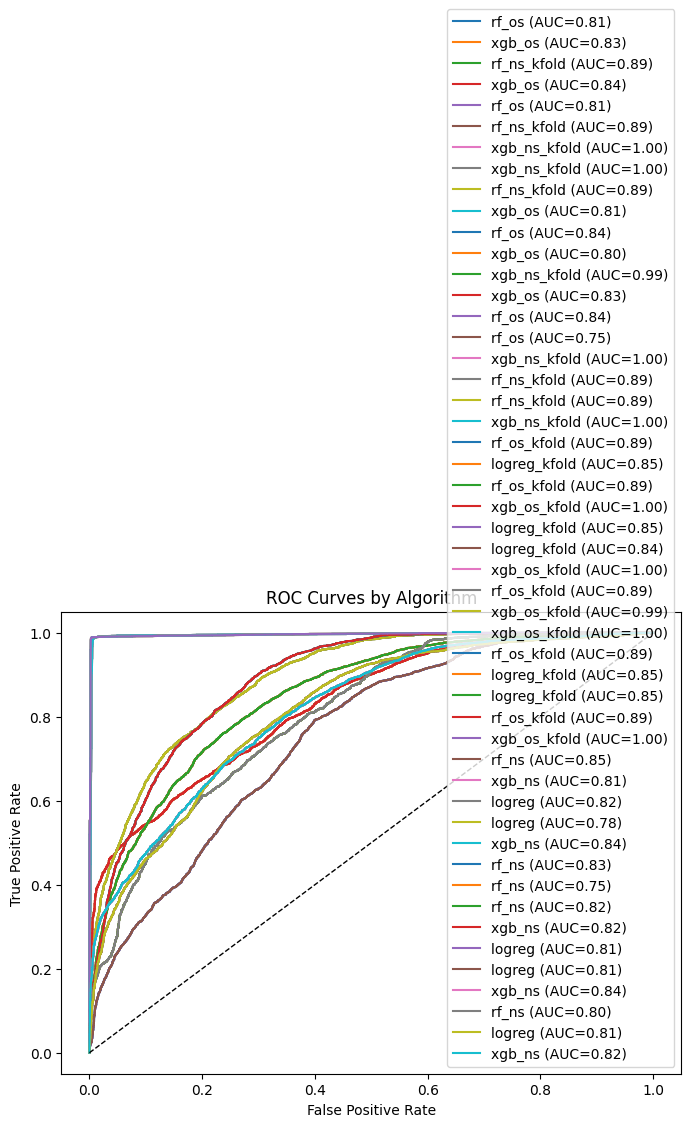

In [41]:
import matplotlib.pyplot as plt

# (이전까지 준비해둔 fpr_map, tpr_map, df_thresh 이용)

plt.figure(figsize=(8,6))
for _, row in df_thresh.iterrows():
    alg = row["alg"]
    plt.plot(fpr_map[alg], tpr_map[alg],
             label=f"{alg} (AUC={row['roc_auc']:.2f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Algorithm")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [42]:
# 1) label 과 alg 를 컬럼으로 올리고
df_show = df_thresh.reset_index(drop=True)

# 2) 컬럼 순서 재배치 (원하는 순서대로)
df_show = df_show[[
    "label", "alg",
    "roc_auc", "best_thresh",
    "precision", "recall", "f1"
]]

# 3) 숫자 포맷 지정
fmt = {
    "roc_auc":    "{:.3f}",
    "best_thresh":"{:.2f}",
    "precision":  "{:.3f}",
    "recall":     "{:.3f}",
    "f1":         "{:.3f}"
}

# 4) 스타일 적용 (수정된 부분만 표시)
(df_show
 .style
 .format(fmt)
 .set_table_styles([
     {"selector":"th", "props":[("background-color","#F0F0F0")]},
     {"selector":"td", "props":[("padding","4px 8px")]}
 ])
 .hide(axis="index")
)

label,alg,roc_auc,best_thresh,precision,recall,f1
attention,rf_os,0.815,0.36,0.687,0.988,0.810
attention,xgb_os,0.826,0.30,0.688,0.849,0.760
attention,rf_ns_kfold,0.893,0.50,0.735,0.923,0.818
attention,xgb_os,0.842,0.30,0.681,0.862,0.761
attention,rf_os,0.809,0.38,0.653,0.980,0.784
attention,rf_ns_kfold,0.890,0.51,0.734,0.912,0.814
attention,xgb_ns_kfold,0.997,0.43,0.995,0.989,0.992
attention,xgb_ns_kfold,0.996,0.48,0.993,0.990,0.991
attention,rf_ns_kfold,0.890,0.49,0.727,0.928,0.815
attention,xgb_os,0.812,0.16,0.654,0.910,0.761


In [43]:
# 0) df_show 준비 (위에서 이미 만드셨다면 재선언 불필요)
df_show = df_thresh.reset_index(drop=True)[[
    "label","alg","roc_auc","best_thresh","precision","recall","f1"
]]

# 1) F1 상위 5개
df_top_f1 = df_show.sort_values(by="f1", ascending=False).head(5)

# 2) ROC AUC 상위 5개
df_top_auc = df_show.sort_values(by="roc_auc", ascending=False).head(5)

# 3) 숫자 포맷 지정
fmt = {
    "roc_auc":     "{:.3f}",
    "best_thresh": "{:.2f}",
    "precision":   "{:.3f}",
    "recall":      "{:.3f}",
    "f1":          "{:.3f}"
}

# 4) 스타일링 & 출력
# ──────────────────────────────────────────────────────────────────────────
styled_f1 = (
    df_top_f1
    .style
    .format(fmt)
    .set_table_styles([
        {"selector":"th", "props":[("background-color","#F0F0F0")]},
        {"selector":"td", "props":[("padding","4px 8px")]}
    ])
    .hide(axis="index")
    .set_caption("🔝 F1 상위 5개 결과")
)

styled_auc = (
    df_top_auc
    .style
    .format(fmt)
    .set_table_styles([
        {"selector":"th", "props":[("background-color","#F0F0F0")]},
        {"selector":"td", "props":[("padding","4px 8px")]}
    ])
    .hide(axis="index")
    .set_caption("🔝 ROC AUC 상위 5개 결과")
)

# Jupyter 에선 아래 두 줄만 실행하시면 순서대로 테이블이 렌더링됩니다.
styled_f1
styled_auc

label,alg,roc_auc,best_thresh,precision,recall,f1
attention,xgb_ns_kfold,0.997,0.43,0.995,0.989,0.992
attention,xgb_os_kfold,0.996,0.35,0.993,0.991,0.992
attention,xgb_ns_kfold,0.996,0.48,0.993,0.990,0.991
attention,xgb_os_kfold,0.996,0.52,0.994,0.989,0.991
attention,xgb_os_kfold,0.996,0.42,0.996,0.989,0.992


In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# 디렉토리 생성
os.makedirs('./fig/confusion_matrices', exist_ok=True)

# metric 분리
cm_metrics = ['true_0_pred_0', 'true_0_pred_1', 'true_1_pred_0', 'true_1_pred_1']
f1_metrics = ['f1_macro', 'f1_micro']
cm_metrics = [f'test_{m}' for m in cm_metrics]
f1_metrics = [f'test_{m}' for m in f1_metrics]

# pivot
mean_cm_df = SUMMARY_EVAL[SUMMARY_EVAL['metric'].isin(cm_metrics)].pivot(index=['label', 'alg'], columns='metric', values='mean')
std_cm_df = SUMMARY_EVAL[SUMMARY_EVAL['metric'].isin(cm_metrics)].pivot(index=['label', 'alg'], columns='metric', values='SD')
f1_df = SUMMARY_EVAL[SUMMARY_EVAL['metric'].isin(f1_metrics)].pivot(index=['label', 'alg'], columns='metric', values='mean')

# 시각화 및 저장
for idx in mean_cm_df.index:
    try:
        mean_cm = np.array([
            [mean_cm_df.loc[idx, 'test_true_0_pred_0'], mean_cm_df.loc[idx, 'test_true_0_pred_1']],
            [mean_cm_df.loc[idx, 'test_true_1_pred_0'], mean_cm_df.loc[idx, 'test_true_1_pred_1']]
        ])
        std_cm = np.array([
            [std_cm_df.loc[idx, 'test_true_0_pred_0'], std_cm_df.loc[idx, 'test_true_0_pred_1']],
            [std_cm_df.loc[idx, 'test_true_1_pred_0'], std_cm_df.loc[idx, 'test_true_1_pred_1']]
        ])
        annotations = np.empty_like(mean_cm, dtype=object)
        for i in range(2):
            for j in range(2):
                annotations[i, j] = f"{mean_cm[i, j]:.1f}±{std_cm[i, j]:.1f}"

        # f1 score 값
        macro_f1 = f1_df.loc[idx, 'test_f1_macro']
        micro_f1 = f1_df.loc[idx, 'test_f1_micro'] if 'test_f1_micro' in f1_df.columns else None

        # 플롯
        plt.figure(figsize=(6, 5))
        sns.heatmap(mean_cm, annot=annotations, fmt='', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
        plt.title(f'Confusion Matrix: {idx[0]} | {idx[1]} (mean ± std)')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

        # 텍스트로 F1 표시
        f1_text = f"Macro F1: {macro_f1:.3f}"
        if micro_f1 is not None:
            f1_text += f" | Micro F1: {micro_f1:.3f}"
        plt.figtext(0.5, -0.05, f1_text, ha='center', fontsize=10)

        # 저장
        filename = f"confmat_{idx[0]}_{idx[1]}.png".replace(" ", "_")
        filepath = os.path.join('./fig/confusion_matrices', filename)
        plt.tight_layout()
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Skipping {idx} due to error: {e}")

In [52]:
worst_splits = RESULTS_EVAL[
    (RESULTS_EVAL['label'] == 'attention') &
    (RESULTS_EVAL['alg'] == 'rf_ns') &
    (RESULTS_EVAL['test_f1_1'] < 1.1)
]
print(worst_splits[['split', 'test_inst_0', 'test_inst_1', 'test_f1_1']])

    split  test_inst_0  test_inst_1  test_f1_1
35  fold2         6468         4893   0.742617
40  fold3         5859         5334   0.772129
41  fold1         6174         5838   0.761541
42  fold4         4410         6027   0.803188
47  fold5         4641         5355   0.754143


# Feature Importances

## Implementation

In [46]:
from typing import Union, Optional


def feature_importance(
    estimator
):
    if not hasattr(estimator, 'feature_names_in_') or not hasattr(estimator, 'feature_importances_'):
        return None
    
    names = estimator.feature_names_in_
    importances = estimator.feature_importances_
    
    return names, importances

## Execution

In [47]:
import os
import pandas as pd
from collections import defaultdict


IMPORTANCE_EVAL = defaultdict(list)
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

for l in ['attention']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        res = load(os.path.join(dir_l, f))

        f_norm = f[:f.index('.pkl')]
        alg = f_norm[:f.rindex('#')]
        
        feat_imp = feature_importance(res.estimator)
        if not feat_imp:
            continue
            
        names, importance = feat_imp
        new_names = []
        for n in names:
            for c in res.categories:
                n = n.replace(f'{c}_', f'{c}=')
            new_names.append(n)
        
        d = pd.DataFrame(
            importance.reshape(1, -1),
            columns=new_names
        )
        IMPORTANCE_EVAL[(l, alg)].append(d)
        

IMPORTANCE_SUMMARY = []

for (l, alg), v in IMPORTANCE_EVAL.items():
    new_v = pd.concat(
        v, axis=0
    ).fillna(0.0).mean().reset_index().set_axis(
        ['feature', 'importance'], axis=1
    ).assign(
        label=l,
        alg=alg
    )
    IMPORTANCE_SUMMARY.append(new_v)
    
IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)


### Plot

In [48]:
%%R -i IMPORTANCE_SUMMARY -w 26 -h 16 -u cm

library(ggplot2)
library(dplyr)
library(stringr)
library(patchwork)

data <- IMPORTANCE_SUMMARY %>% filter(label == 'attention')

p_label <- ggplot() + geom_text(
    aes(x = .5, y = .5),
    label = 'Attention',
    family = 'ssp',
    fontface = 'bold',
    size = 4
) + theme_void()

p_rf <- ggplot(
    data %>% filter(alg == 'rf_os') %>% top_n(n = 10, wt = importance),
    aes(x = reorder(feature, -importance), y = importance)
) + geom_col() +
    THEME_DEFAULT + theme(
        axis.text.x = element_text(angle = 90, size = 10, hjust = 1, vjust = .5),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()
    ) + labs(subtitle = 'Random Forest')

p_xgb <- ggplot(
    data %>% filter(alg == 'xgb_os') %>% top_n(n = 10, wt = importance),
    aes(x = reorder(feature, -importance), y = importance)
) + geom_col() +
    THEME_DEFAULT + theme(
        axis.text.x = element_text(angle = 90, size = 10, hjust = 1, vjust = .5),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()
    ) + labs(subtitle = 'XGBoost')

p <- p_label / (p_rf | p_xgb) + plot_layout(heights = c(1.1, 10))

ggsave('./fig/imp_attention.pdf', plot = p, width = 26, height = 16, unit = 'cm', device = cairo_pdf)
print(p)

UsageError: Cell magic `%%R` not found.
